# 2A_mpra_gene_analysis-barcodeallele

09/25/2020

In [38]:
import pandas as pd
import os, glob,sys
import seaborn as sns
import collections
import numpy as np
import scipy.stats
import pybedtools
import matplotlib.pyplot as plt

# 0. setup lib

In [2]:
diseases =sorted( ['schizo', 'depress', 'bipolar', 'anxiety', 'attent',
 'personality', 'panic', 'traum', 'autism', 'ocd'])

In [3]:
print(sys.path)

['/Users/mguo123/Google Drive/1_khavari/noncancer_project/miseq/novogene_071420', '/Users/mguo123/opt/anaconda3/lib/python37.zip', '/Users/mguo123/opt/anaconda3/lib/python3.7', '/Users/mguo123/opt/anaconda3/lib/python3.7/lib-dynload', '', '/Users/mguo123/.local/lib/python3.7/site-packages', '/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages', '/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/aeosa', '/Users/mguo123/Google Drive/1_khavari/omics_project-LD/pan_omics/src/irf', '/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/MOODS_python-1.9.4.1-py3.7-macosx-10.9-x86_64.egg', '/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/Users/mguo123/.ipython']


In [4]:
lib_csv = '../../psych_lib_info.csv'
lib_df = pd.read_csv(lib_csv,index_col=0)
lib_df['name_abbr']= lib_df.Chr + '_' + lib_df.Position.map(str)

print(lib_df.columns.values)
print(lib_df.shape)
print(lib_df.name_abbr.value_counts().shape)
lib_df[:5]

['name' 'X' 'Linked_SNP' 'Chr' 'Position' 'Index_SNP' 'Disease'
 'DHS_tissue' 'eGene' 'eQTL_tissue' 'Pval' 'source' 'RS' 'pos' 'info'
 'allele_type' 'allele' 'seq150_new' 'seq21_new' 'schizo' 'depress'
 'bipolar' 'anxiety' 'attent' 'personality' 'panic' 'traum' 'autism' 'ocd'
 'Ref' 'Alt' 'Type' 'Length' 'AnnoType' 'Consequence' 'ConsScore'
 'ConsDetail' 'GC' 'CpG' 'motifECount' 'motifEName' 'motifEHIPos'
 'motifEScoreChng' 'oAA' 'nAA' 'GeneID' 'FeatureID' 'GeneName' 'CCDS'
 'Intron' 'Exon' 'cDNApos' 'relcDNApos' 'CDSpos' 'relCDSpos' 'protPos'
 'relProtPos' 'Domain' 'Dst2Splice' 'Dst2SplType' 'minDistTSS'
 'minDistTSE' 'SIFTcat' 'SIFTval' 'PolyPhenCat' 'PolyPhenVal' 'priPhCons'
 'mamPhCons' 'verPhCons' 'priPhyloP' 'mamPhyloP' 'verPhyloP' 'bStatistic'
 'targetScan' 'mirSVR.Score' 'mirSVR.E' 'mirSVR.Aln' 'cHmmTssA'
 'cHmmTssAFlnk' 'cHmmTxFlnk' 'cHmmTx' 'cHmmTxWk' 'cHmmEnhG' 'cHmmEnh'
 'cHmmZnfRpts' 'cHmmHet' 'cHmmTssBiv' 'cHmmBivFlnk' 'cHmmEnhBiv'
 'cHmmReprPC' 'cHmmReprPCWk' 'cHmmQuies'

/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (63,65) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,name,X,Linked_SNP,Chr,Position,Index_SNP,Disease,DHS_tissue,eGene,eQTL_tissue,...,dbscSNV.ada_score,dbscSNV.rf_score,RawScore,PHRED,num_disease,disease_interest,pass_thres_low,pass_thres,CADD_score_bool,name_abbr
1,chr1.111243375.all_alt.G,75004,rs12085135,chr1,111243375,rs12061304,panic disorder,t-helper_17_cell,NaN,NaN,...,NaN,NaN,-0.197208,0.728,1,True,True,False,NaN,chr1_111243375
2,chr1.111243375.Ref.C,75004,rs12085135,chr1,111243375,rs12061304,panic disorder,t-helper_17_cell,NaN,NaN,...,NaN,NaN,-0.197208,0.728,1,True,True,False,NaN,chr1_111243375
3,chr1.113938499.all_alt.C,1977,rs74395031,chr1,113938499,rs115870915,"type 2 diabetes,Obsessive Compulsive Disorder",astrocyte_of_the_spinal_cord,NaN,NaN,...,NaN,NaN,0.309426,7.336,1,True,True,True,NaN,chr1_113938499
4,chr1.113938499.Ref.T,1977,rs74395031,chr1,113938499,rs115870915,"type 2 diabetes,Obsessive Compulsive Disorder",astrocyte_of_the_spinal_cord,NaN,NaN,...,NaN,NaN,0.309426,7.336,1,True,True,True,NaN,chr1_113938499
5,chr1.11712109.all_alt.T,569,rs2103665,chr1,11712109,rs115049252,schizo,spleen,NaN,NaN,...,NaN,NaN,0.193843,5.751,1,False,True,True,NaN,chr1_11712109


In [5]:
snp_loc_to_linked_rsid = pd.Series(lib_df.Linked_SNP.values, index=lib_df.name_abbr.values).to_dict()
snp_loc_to_index_rsid = pd.Series(lib_df.Index_SNP.values, index=lib_df.name_abbr.values).to_dict()


### get nearest_genes

In [6]:
# MAX_DIST = 100000

In [7]:
gene_region = pd.read_csv('/Users/mguo123/Google Drive/1_khavari/omics_project-LD/pan_omics/data/external/gencode.v19.gene.bed',sep='\t',header=None)
gene_region.columns = ['chr','start','stop','gene']
gene_region_bed = pybedtools.BedTool.from_dataframe(gene_region).sort()

exon_region = pd.read_csv('/Users/mguo123/Google Drive/1_khavari/omics_project-LD/pan_omics/data/external/gencode.v19.exon.bed',sep='\t',header=None)
exon_region.columns = ['chr','start','stop','gene']
exon_region_bed = pybedtools.BedTool.from_dataframe(exon_region).sort()

TSS_file = '/Users/mguo123/Google Drive/1_khavari/omics_project-LD/pan_omics/data/external/TSS_annon_hg19.csv'
TSS_df = pd.read_csv(TSS_file,index_col=0)
TSS_df['stop'] = TSS_df['loc']+1
TSS_df = TSS_df[['chr', 'loc','stop','TSS']]
TSS_df.columns = ['chr','start','stop','TSS']
TSS_bed = pybedtools.BedTool.from_dataframe(TSS_df).sort()
TSS_df[:5]

,chr,start,stop,TSS
0,chr1,1846266,1846267,CALML6
1,chr1,231376933,231376934,C1orf131
2,chr1,241683061,241683062,FH
3,chr1,120202421,120202422,PHGDH
4,chr1,204135465,204135466,REN


In [8]:
gwas_df = lib_df[['Chr','Position','name_abbr']]
gwas_df.columns = ['chr','start','name']
gwas_df['stop'] = gwas_df.start +1
gwas_df = gwas_df[['chr','start','stop','name']]
gwas_bed = pybedtools.BedTool.from_dataframe(gwas_df).sort()
gwas_bed.to_dataframe()[:5]

/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,chrom,start,end,name
0,chr1,2069681,2069682,chr1_2069681
1,chr1,2069681,2069682,chr1_2069681
2,chr1,2337032,2337033,chr1_2337032
3,chr1,2337032,2337033,chr1_2337032
4,chr1,2337277,2337278,chr1_2337277


In [9]:
gwas_ngene_bed = gwas_bed.closest(TSS_bed,d=True)
gwas_ngene_bed.saveas(os.path.join('../../psych_lib_ngene_TSS.bed'))
gwas_ngene_df = gwas_ngene_bed.to_dataframe()
gwas_ngene_df = gwas_ngene_df[['name','thickEnd','itemRgb']]
gwas_ngene_df.columns = ['snp_id','TSS','distance']
gwas_ngene_df = gwas_ngene_df.merge(lib_df, how='left', left_on='snp_id',right_on='name_abbr')
# gwas_ngene_df = gwas_ngene_df[gwas_ngene_df.distance < MAX_DIST]
print(gwas_ngene_df.TSS.unique().shape)
gwas_ngene_df[:5]


(746,)


,snp_id,TSS,distance,name,X,Linked_SNP,Chr,Position,Index_SNP,Disease,...,dbscSNV.ada_score,dbscSNV.rf_score,RawScore,PHRED,num_disease,disease_interest,pass_thres_low,pass_thres,CADD_score_bool,name_abbr
0,chr1_2069681,AL590822.2,51556,chr1.2069681.all_alt.T,1545,rs3753242,chr1,2069681,rs3753242,Schizophrenia,...,NaN,NaN,-0.131842,1.130,1,False,True,True,True,chr1_2069681
1,chr1_2069681,AL590822.2,51556,chr1.2069681.Ref.C,1545,rs3753242,chr1,2069681,rs3753242,Schizophrenia,...,NaN,NaN,-0.131842,1.130,1,False,True,True,True,chr1_2069681
2,chr1_2069681,AL590822.2,51556,chr1.2069681.all_alt.T,1545,rs3753242,chr1,2069681,rs3753242,Schizophrenia,...,NaN,NaN,-0.131842,1.130,1,False,True,True,True,chr1_2069681
3,chr1_2069681,AL590822.2,51556,chr1.2069681.Ref.C,1545,rs3753242,chr1,2069681,rs3753242,Schizophrenia,...,NaN,NaN,-0.131842,1.130,1,False,True,True,True,chr1_2069681
4,chr1_2337032,PEX10,8204,chr1.2337032.all_alt.T,451,rs1129171,chr1,2337032,NaN,schizo,...,NaN,NaN,-0.093925,1.458,1,False,True,True,NaN,chr1_2337032


In [10]:
snp_to_annongene_dict = pd.Series(lib_df.GeneName.values, index=lib_df.name_abbr.values).to_dict()


In [11]:
snp_to_ngene_df = gwas_ngene_df[['snp_id','TSS']].drop_duplicates()#.snp_id.value_counts()
snp_to_ngene_dict = pd.Series(snp_to_ngene_df.TSS.values, index=snp_to_ngene_df.snp_id.values).to_dict()



In [12]:
#one case with 2
print(gwas_ngene_df[gwas_ngene_df.snp_id=='chr14_104029449'].TSS.unique())
snp_to_ngene_dict['chr14_104029449'] = 'APOPT1'

['APOPT1' 'RP11-73M18.2']


In [13]:
len(snp_to_ngene_dict)

2221

# 1. get results

In [14]:
test_df = pd.read_csv('mpraanalyze_SL_comp_filt.csv',index_col=0)
test_df[:5]

,rowname,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC,neglog10_p,...,Sngl10000bp,dbscSNV.ada_score,dbscSNV.rf_score,RawScore,PHRED,num_disease,disease_interest,pass_thres_low,pass_thres,CADD_score_bool
1,chr1_8510577,74.945625,4.838583e-18,2.134783e-15,1,10,3,2,1.049664,17.315282,...,649,NaN,NaN,-0.148330,1.011,1,True,True,True,NaN
2,chr1_8510577,74.945625,4.838583e-18,2.134783e-15,1,10,3,2,1.049664,17.315282,...,649,NaN,NaN,-0.148330,1.011,1,True,True,True,NaN
3,chr6_26104630,114.908135,8.242891e-27,6.061272e-24,1,14,3,2,0.637511,26.083920,...,774,NaN,NaN,0.173411,5.440,1,False,True,True,True
4,chr6_26104630,114.908135,8.242891e-27,6.061272e-24,1,14,3,2,0.637511,26.083920,...,774,NaN,NaN,0.173411,5.440,1,False,True,True,True
5,chr5_159602823,108.925049,1.685399e-25,9.294977e-23,1,13,3,2,0.633682,24.773297,...,599,NaN,NaN,1.243442,14.650,1,False,True,False,True


In [15]:
test_df.fdr.describe()

count    1.420000e+02
mean     1.135748e-02
std      1.473056e-02
min      1.875372e-33
25%      2.843680e-04
50%      3.676142e-03
75%      1.731315e-02
max      4.868428e-02
Name: fdr, dtype: float64

In [16]:
final_df = pd.DataFrame()
for mpra_res_file in glob.glob('D_mpraanalyze_barcode_allelic/mpraanalyze_*comp.csv'):
    tissue = os.path.basename(mpra_res_file).split('_')[1]
    res_df = pd.read_csv(mpra_res_file,index_col=0)
    res_df = res_df.merge(lib_df, how='left',left_on='rowname',right_on='name_abbr')
    res_df['tissue'] = tissue
    print(tissue,res_df.shape)
    final_df = pd.concat([final_df, res_df], axis=0)

AST1 (4257, 152)
H9D2 (4297, 152)
H9D10 (4267, 153)
H9D4 (4305, 152)


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


H9D0 (4221, 152)
HEK293 (4382, 153)
SLC (4325, 152)
SL (4325, 152)


In [17]:
print(final_df.columns.values)
final_df.shape

['Alt' 'AnnoType' 'CADD_score_bool' 'CCDS' 'CDSpos' 'Chr' 'ConsDetail'
 'ConsScore' 'Consequence' 'CpG' 'DHS_tissue' 'Disease' 'Dist2Mutation'
 'Domain' 'Dst2SplType' 'Dst2Splice' 'EncExp' 'EncH3K27Ac' 'EncH3K4Me1'
 'EncH3K4Me3' 'EncNucleo' 'EncOCC' 'EncOCCombPVal' 'EncOCDNasePVal'
 'EncOCDNaseSig' 'EncOCFairePVal' 'EncOCFaireSig' 'EncOCctcfPVal'
 'EncOCctcfSig' 'EncOCmycPVal' 'EncOCmycSig' 'EncOCpolIIPVal'
 'EncOCpolIISig' 'Exon' 'FeatureID' 'Freq10000bp' 'Freq1000bp' 'Freq100bp'
 'GC' 'GeneID' 'GeneName' 'GerpN' 'GerpRS' 'GerpRSpval' 'GerpS' 'Grantham'
 'Index_SNP' 'Intron' 'Length' 'Linked_SNP' 'PHRED' 'PolyPhenCat'
 'PolyPhenVal' 'Position' 'Pval' 'RS' 'Rare10000bp' 'Rare1000bp'
 'Rare100bp' 'RawScore' 'Ref' 'SIFTcat' 'SIFTval' 'Segway' 'Sngl10000bp'
 'Sngl1000bp' 'Sngl100bp' 'TFBS' 'TFBSPeaks' 'TFBSPeaksMax' 'Type' 'X'
 'X_x' 'X_y' 'allele' 'allele_type' 'anxiety' 'attent' 'autism'
 'bStatistic' 'bipolar' 'cDNApos' 'cHmmBivFlnk' 'cHmmEnh' 'cHmmEnhBiv'
 'cHmmEnhG' 'cHmmHet' 'cHmmQu

(34379, 154)

In [18]:
final_df_filt = final_df[final_df.fdr<0.05]
# p_thres = 0.05/lib_df.shape[0]
# final_df_filt = final_df[final_df.pval<p_thres]

final_df.shape,final_df_filt.shape

((34379, 154), (2584, 154))

In [19]:
final_df_filt[['pval','fdr']].describe()

,pval,fdr
count,2.584000e+03,2.584000e+03
mean,1.286182e-03,1.648085e-02
std,1.677194e-03,1.581820e-02
min,8.501233e-37,1.875372e-33
25%,2.870233e-05,1.205139e-03
50%,5.331687e-04,1.175887e-02
75%,1.893691e-03,2.916501e-02
max,7.702637e-03,4.977435e-02


In [20]:
final_df.to_csv('D_mpraanalyze_barcode_allelic/final_df.csv')

In [21]:
final_df[:5]

,Alt,AnnoType,CADD_score_bool,CCDS,CDSpos,Chr,ConsDetail,ConsScore,Consequence,CpG,...,seq150_new,seq21_new,source,statistic,tOverlapMotifs,targetScan,tissue,traum,verPhCons,verPhyloP
0,A,Transcript,True,CCDS3659.1,NaN,chr4,intron,2,INTRONIC,0.013333,...,CATGTAGTGTCACTAGTGAAGCAGTGCTTCTCAAACTAGTGTCCAT...,TGTTGAAAATACGACTTTGAT,gwas,98.811484,NaN,NaN,AST1,0,0.0,0.010
1,A,Transcript,True,CCDS3659.1,NaN,chr4,intron,2,INTRONIC,0.013333,...,CATGTAGTGTCACTAGTGAAGCAGTGCTTCTCAAACTAGTGTCCAT...,TGTTGAAAATGCGACTTTGAT,gwas,98.811484,NaN,NaN,AST1,0,0.0,0.010
2,A,Transcript,NaN,CCDS5358.1,NaN,chr7,intron,2,INTRONIC,0.000000,...,CATAACTTCATTAGCACCTTATAACTCCCAGGATTTGGTTGCTATC...,ATCATTACTAATTAATTTTGT,gwas,93.454711,NaN,NaN,AST1,0,0.0,-0.122
3,A,Transcript,NaN,CCDS5358.1,NaN,chr7,intron,2,INTRONIC,0.000000,...,CATAACTTCATTAGCACCTTATAACTCCCAGGATTTGGTTGCTATC...,ATCATTACTAGTTAATTTTGT,gwas,93.454711,NaN,NaN,AST1,0,0.0,-0.122
4,A,Intergenic,True,CCDS43393.1,NaN,chr5,upstream,1,UPSTREAM,0.053333,...,CAAAAGCAGTAAGAGAGTGCCCAGCAGTATCAGGGATGATAAGGAC...,ATGGCATTTCAGACCTCCAGA,gwas,74.726071,NaN,NaN,AST1,0,0.0,-0.542


In [22]:
final_df_filt = final_df_filt[diseases+['rowname','GeneName','tissue','pval','fdr','logFC','DHS_tissue','PHRED']]
final_df_filt['ngene'] = final_df_filt.rowname.map(snp_to_ngene_dict)
final_df_filt.fillna('',inplace=True)

In [23]:
final_df_filt.logFC.map(abs).describe()


count    2584.000000
mean        1.112895
std         0.759758
min         0.010248
25%         0.708294
50%         0.953775
75%         1.256477
max         8.309716
Name: logFC, dtype: float64

# 2. analyze

### compare the PHRED SCORES OF THE MPRA significant genes, and the ones originally tested set

In [24]:
# look at distrbutitions'
phred_df = lib_df[['PHRED','name_abbr']].drop_duplicates()
phred_df.columns = ['PHRED','rowname']
phred_df['type'] = 'library'
phred_df.PHRED.describe()

count    2221.000000
mean        5.486179
std         5.272465
min         0.002000
25%         1.518000
50%         4.050000
75%         7.765000
max        69.000000
Name: PHRED, dtype: float64

In [25]:
phred_df_sig = final_df_filt[['PHRED','rowname']].drop_duplicates()
phred_df_sig['type'] = 'sig'
phred_df_sig.PHRED.describe()

count    637.000000
mean       5.723862
std        5.397621
min        0.006000
25%        1.633000
50%        4.338000
75%        8.132000
max       52.000000
Name: PHRED, dtype: float64

In [26]:
scipy.stats.ks_2samp(phred_df.PHRED.values, phred_df_sig.PHRED.values)

Ks_2sampResult(statistic=0.030844436967804822, pvalue=0.7194981735838794)

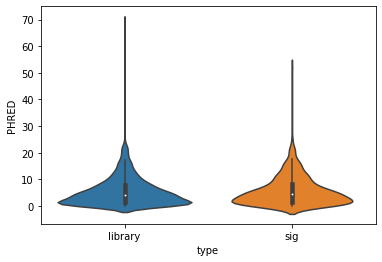

In [27]:
phred_df_all = pd.concat([phred_df,phred_df_sig],axis=0)
sns.violinplot(x="type", y="PHRED", data=phred_df_all)

they aren'e significant

# TISSUE TYPE


In [28]:
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt

,rowname,tissue,logFC
0,chr4_103750316,AST1,4.841936
2,chr7_12261911,AST1,3.258018
4,chr5_159609391,AST1,1.777071
6,chr4_114355562,AST1,1.962058
8,chr11_47365014,AST1,2.912401
...,...,...,...
4315,chr11_57435211,SL,-3.062723
4317,chr2_12569011,SL,-1.398837
4319,chr17_57502828,SL,-1.187129
4321,chr14_91287534,SL,-3.267662


In [49]:
def consensus_direction(row):
    counter = collections.Counter(row.values)
    if counter.get(1,0) > counter.get(-1,0):
        return 1
    elif counter.get(1,0) < counter.get(-1,0):
        return -1
    else:
        return 0

In [67]:
tissue_snp_df = final_df_filt[['rowname','tissue','logFC']].drop_duplicates()#final_df_filt[['rowname','tissue']].drop_duplicates()
# tissue_snp_df['bool'] = 1
# tissue_snp_df = tissue_snp_df.pivot(index='rowname',columns='tissue',values='bool').fillna(0)
# make sure HEK is in the right direction
tissue_snp_df['logFC'] = tissue_snp_df['logFC'].apply(lambda x: 1 if x >0 else -1)
tissue_snp_df = tissue_snp_df.pivot(index='rowname',columns='tissue',values='logFC').fillna(0)
# tissue_snp_df['HEK293'] = pd.Series(tissue_snp_df.drop('HEK293',axis=1).apply(consensus_direction,axis=1) == tissue_snp_df.HEK293).map(float)
# tissue_snp_df = abs(tissue_snp_df)



tissue,AST1,H9D0,H9D10,H9D2,H9D4,HEK293,SL,SLC
rowname,,,,,,,,
chr10_104556054,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
chr10_104598322,0.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0,0.0
chr10_106207209,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
chr10_25211437,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
chr10_30728250,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...
chr9_26892301,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
chr9_26949686,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0
chr9_7171606,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0


In [77]:
pd.Series(tissue_snp_df[tissue_snp_df.HEK293!=0].drop('HEK293',axis=1).apply(
    consensus_direction,axis=1) == tissue_snp_df[tissue_snp_df.HEK293!=0].HEK293).map(float).value_counts()




1.0    177
0.0     96
dtype: int64

In [60]:
tissue_snp_df_HEK_AST_H9 = tissue_snp_df[['AST1','HEK293']]
tissue_snp_df_HEK_AST_H9['H9D0'] = tissue_snp_df[['H9D0']].max(axis=1)
tissue_snp_df_HEK_AST_H9['H9'] = tissue_snp_df[['H9D0', 'H9D10', 'H9D2', 'H9D4',  'SL', 'SLC']].max(axis=1)
tissue_snp_df_HEK_AST_H9['H9_diff'] = tissue_snp_df[['H9D10', 'H9D2', 'H9D4',  'SL', 'SLC']].max(axis=1)
HEK_set = set(tissue_snp_df_HEK_AST_H9[tissue_snp_df_HEK_AST_H9.HEK293==1].index)
H9D0_set = set(tissue_snp_df_HEK_AST_H9[tissue_snp_df_HEK_AST_H9.H9D0==1].index)
H9_set = set(tissue_snp_df_HEK_AST_H9[tissue_snp_df_HEK_AST_H9.H9==1].index)
H9_diff_set = set(tissue_snp_df_HEK_AST_H9[tissue_snp_df_HEK_AST_H9.H9_diff==1].index)
AST_set = set(tissue_snp_df_HEK_AST_H9[tissue_snp_df_HEK_AST_H9.AST1==1].index)


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [61]:
tissue_snp_df_HEK_AST_H9.describe()

tissue,AST1,HEK293,H9D0,H9,H9_diff
count,637.000000,637.000000,637.000000,637.000000,637.000000
mean,0.103611,0.284144,0.164835,0.833595,0.759812
std,0.304994,0.451360,0.371323,0.372736,0.427533
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,1.000000
50%,0.000000,0.000000,0.000000,1.000000,1.000000
75%,0.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


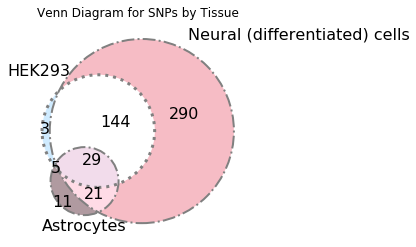

In [62]:
vd3=venn3([set(HEK_set),set(H9_diff_set),set(AST_set)],
 set_labels=('HEK293','Neural (differentiated) cells','Astrocytes'),
 set_colors=('#c4e6ff','#F4ACB7','#9D8189'), 
 alpha = 0.8)
c=venn3_circles([set(HEK_set), set(H9_diff_set),set(AST_set)], linestyle='-.', linewidth=2, color='grey')
for text in vd3.set_labels:
 text.set_fontsize(16);
for text in vd3.subset_labels:
 text.set_fontsize(16)
plt.title('Venn Diagram for SNPs by Tissue')#,fontname='Times New Roman',fontweight='bold',fontsize=20,
#  pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
c[0].set_lw(3.0) #customize upper left circle 
c[0].set_ls(':')
# plt.savefig('D_mpraanalyze_barcode_allelic/snp_by_tissue_venn_diff.pdf',dpi=300)
plt.show()


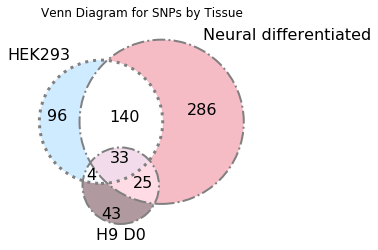

In [240]:
vd3=venn3([set(HEK_set),set(H9_diff_set),set(H9D0_set)],
 set_labels=('HEK293','Neural differentiated','H9 D0'),
 set_colors=('#c4e6ff','#F4ACB7','#9D8189'), 
 alpha = 0.8)
c=venn3_circles([set(HEK_set), set(H9_diff_set),set(H9D0_set)], linestyle='-.', linewidth=2, color='grey')
for text in vd3.set_labels:
 text.set_fontsize(16);
for text in vd3.subset_labels:
 text.set_fontsize(16)
plt.title('Venn Diagram for SNPs by Tissue')#,fontname='Times New Roman',fontweight='bold',fontsize=20,
#  pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
c[0].set_lw(3.0) #customize upper left circle 
c[0].set_ls(':')
plt.savefig('D_mpraanalyze_barcode_allelic/snp_by_tissue_venn_H9_H9D0.pdf',dpi=300)
plt.show()


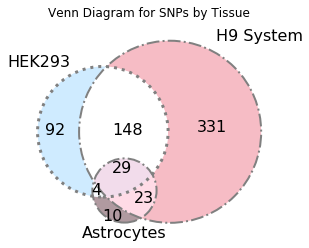

In [241]:
vd3=venn3([set(HEK_set),set(H9_set),set(AST_set)],
 set_labels=('HEK293','H9 System','Astrocytes'),
 set_colors=('#c4e6ff','#F4ACB7','#9D8189'), 
 alpha = 0.8)
c=venn3_circles([set(HEK_set), set(H9_set),set(AST_set)], linestyle='-.', linewidth=2, color='grey')
for text in vd3.set_labels:
 text.set_fontsize(16);
for text in vd3.subset_labels:
 text.set_fontsize(16)
plt.title('Venn Diagram for SNPs by Tissue')#,fontname='Times New Roman',fontweight='bold',fontsize=20,
#  pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
c[0].set_lw(3.0) #customize upper left circle 
c[0].set_ls(':')
plt.savefig('D_mpraanalyze_barcode_allelic/snp_by_tissue_venn.pdf',dpi=300)
plt.show()


### snp regions and disease types

In [24]:
final_df_filt.rowname.value_counts()

chr13_44282397    16
chr1_8484823      16
chr6_32165444     16
chr9_121358237    16
chr1_11840483     15
                  ..
chr1_34041117      2
chr19_6077059      2
chr9_94863064      2
chr14_77292642     2
chr14_67435182     1
Name: rowname, Length: 637, dtype: int64

there are 92 snp regions that had significant ASE across the different tissues


In [25]:
final_df_filt[diseases+['rowname']].drop_duplicates()[diseases].sum(axis=0)

anxiety         56
attent          46
autism          10
bipolar        105
depress        117
ocd             36
panic           15
personality     12
schizo         322
traum           30
dtype: int64

These are the  snps that are signficant per disease (regardless of tissue type)


In [26]:
disease_types = pd.DataFrame({'library': lib_df[diseases+['name_abbr']].drop_duplicates()[diseases].sum(axis=0),
             'sig':final_df_filt[diseases+['rowname']].drop_duplicates()[diseases].sum(axis=0)})
disease_types['frac']  = disease_types.sig/ disease_types.library
disease_types

,library,sig,frac
anxiety,179,56,0.312849
attent,142,46,0.323944
autism,54,10,0.185185
bipolar,400,105,0.262500
depress,424,117,0.275943
ocd,116,36,0.310345
panic,61,15,0.245902
personality,39,12,0.307692
schizo,1067,322,0.301781
traum,101,30,0.297030


In [164]:
# pd.melt(final_df_filt[diseases+['tissue']], id_vars=diseases, value_vars=['tissue'])
#final_df_filt[diseases+['tissues']].pivot(values='X', index=['Y','Z'], columns='X', aggfunc='count')
tissue_disease_df = final_df_filt[diseases+['tissue']].groupby('tissue').sum(axis=1)
tissue_disease_df


,anxiety,attent,autism,bipolar,depress,ocd,panic,personality,schizo,traum
tissue,,,,,,,,,,
AST1,10,10,2,27,26,6,0,4,71,4
H9D0,30,10,2,36,27,14,6,2,105,2
H9D10,28,22,4,61,48,12,10,0,176,10
H9D2,14,10,2,39,20,14,4,4,96,8
H9D4,30,24,6,58,70,24,8,6,205,22
HEK293,42,32,8,83,109,40,14,14,264,22
SL,6,14,0,30,26,6,4,2,82,4
SLC,58,54,10,102,119,34,17,8,361,38


In [165]:
tissue_disease_df.to_csv('tissue_disease_df.csv')
tissue_disease_df.reset_index().melt('tissue').to_csv('D_mpraanalyze_barcode_allelic/tissue_disease_df_long.csv')

this the breakdown of tissues eval by dosease type

In [27]:
snp_disease_df = final_df_filt[['rowname']+diseases].drop_duplicates()
snp_disease_df['num_dz'] = snp_disease_df[diseases].sum(axis=1)
snp_disease_df.sort_values('num_dz')

,rowname,anxiety,attent,autism,bipolar,depress,ocd,panic,personality,schizo,traum,num_dz
0,chr4_103750316,0,0,0,0,0,0,0,0,1,0,1
119,chr1_8123684,0,0,0,0,1,0,0,0,0,0,1
129,chr9_7180490,0,0,0,0,0,0,0,0,1,0,1
147,chr11_47358997,0,0,0,0,0,0,0,0,1,0,1
151,chr6_27059443,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
187,chr9_132599101,0,1,0,1,1,0,0,0,1,0,4
95,chr9_132597840,0,1,0,1,1,0,0,0,1,0,4
3749,chr9_132596899,0,1,0,1,1,0,0,0,1,0,4
4082,chr9_132601229,0,1,0,1,1,0,0,0,1,0,4


In [28]:
snp_disease_df.num_dz.value_counts()

1    556
2     56
3     19
4      6
Name: num_dz, dtype: int64

In [29]:
high_dz_snps = snp_disease_df[snp_disease_df.num_dz==4].rowname.values
print(high_dz_snps)

['chr9_132565943' 'chr9_132597840' 'chr9_132597721' 'chr9_132599101'
 'chr9_132596899' 'chr9_132601229']


this is the snp breakdown by disea

In [30]:
final_df_filt[['rowname','tissue']].drop_duplicates().rowname.value_counts()

chr9_121358237    8
chr13_44282397    8
chr1_8484823      8
chr1_159140851    7
chr3_44042297     7
                 ..
chr1_34041117     1
chr19_6077059     1
chr9_94863064     1
chr7_110872556    1
chr14_77292642    1
Name: rowname, Length: 637, dtype: int64

### make snp to gene tables to fill in with cgene and egene info

In [33]:
snp_df = final_df_filt.groupby('rowname').agg({'GeneName':lambda x: '|'.join(list(set(x))),
                                      'ngene':lambda x: '|'.join(list(set(x))),
                                      'tissue':lambda x: '|'.join(list(set(x)))
                                     })
snp_df

,GeneName,ngene,tissue
rowname,,,
chr10_104359350,,TRIM8,H9D0
chr10_104426177,,TRIM8,SL|SLC
chr10_104556054,,CYP17A1,HEK293
chr10_104598322,CYP17A1-AS1,CYP17A1,H9D4|HEK293|H9D10|H9D0
chr10_104767185,CNNM2,CNNM2,H9D4|SLC|AST1|H9D2
...,...,...,...
chr9_7180490,KDM4C,KDM4C,HEK293|SLC
chr9_94863064,,SPTLC1,SLC
chr9_94877836,MTND4P15,SPTLC1,H9D10


In [34]:
snp_to_ngene_dict['chr1_8484823']

'SLC45A1'

In [35]:
snp_to_annongene_dict['chr1_8484823']

'RERE'

In [36]:
snp_all_results = snp_df.reset_index().merge(snp_disease_df, how='left', left_on='rowname', right_on = 'rowname')
snp_all_results['Linked_SNP']= snp_all_results.rowname.map(snp_loc_to_linked_rsid)
snp_all_results['Index_SNP']= snp_all_results.rowname.map(snp_loc_to_index_rsid)

In [37]:
snp_all_results

,rowname,GeneName,ngene,tissue,anxiety,attent,autism,bipolar,depress,ocd,panic,personality,schizo,traum,num_dz,Linked_SNP,Index_SNP
0,chr10_104359350,,TRIM8,H9D0,0,0,0,0,0,0,0,0,1,0,1,rs3824756,rs9665626
1,chr10_104426177,,TRIM8,SL|SLC,0,0,0,0,0,0,0,0,1,0,1,rs4244354,rs10883765
2,chr10_104556054,,CYP17A1,HEK293,0,0,0,0,0,0,0,0,1,0,1,rs176185,"rs16977195,rs284844"
3,chr10_104598322,CYP17A1-AS1,CYP17A1,H9D4|HEK293|H9D10|H9D0,0,0,0,1,0,0,0,0,1,0,2,rs10786713,"rs7085104,rs11191424,rs11191419"
4,chr10_104767185,CNNM2,CNNM2,H9D4|SLC|AST1|H9D2,0,1,0,1,0,0,0,0,1,0,3,rs12264415,rs7914558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,chr9_7180490,KDM4C,KDM4C,HEK293|SLC,0,0,0,0,0,0,0,0,1,0,1,rs2820927,"rs2026714,rs7022054"
633,chr9_94863064,,SPTLC1,SLC,0,0,0,1,0,0,0,0,1,0,2,rs12337180,rs7872515
634,chr9_94877836,MTND4P15,SPTLC1,H9D10,0,0,0,1,0,0,0,0,1,0,2,rs10992234,rs7872515
635,chr9_98824232,,ERCC6L2,H9D0,1,0,0,0,0,0,0,0,0,0,1,rs10481697,rs7867155


In [176]:
snp_all_results.to_csv('D_mpraanalyze_barcode_allelic/snp_all_results.csv')


# HaploReg v4 annotation

take list of linked snps --> txt file

unloaded to haploreg v4, but formmating weird so will be scraping

In [80]:
import requests
import re
from collections import defaultdict
# import json
# from lxml import html
# from lxml.html.clean import clean_html
# from html.parser import HTMLParser

# class MyHTMLParser(HTMLParser):
#     def handle_starttag(self, tag, attrs):
#         print("Encountered a start tag:", tag)

#     def handle_endtag(self, tag):
#         print("Encountered an end tag :", tag)

#     def handle_data(self, data):
#         print("Encountered some data  :", data)

# parser = MyHTMLParser()


testing

In [81]:
# response = requests.get('https://pubs.broadinstitute.org/mammals/haploreg/detail_v4.1.php?query=&id=rs3824756')
response = requests.get('https://pubs.broadinstitute.org/mammals/haploreg/detail_v4.1.php?query=&id=rs7174985')

In [82]:
table_lines =re.findall(r'<tr>(.*?)</tr>', str(response.content), re.M|re.I|re.S)

type_table = ''
# freq: [' rowspan=2><b>chr</b>', ' rowspan=2><b>pos (hg19)</b><td rowspan=2><b>chr</b>', ' rowspan=2><b>pos (hg38)</b><td rowspan=2><b>Reference</b>', ' rowspan=2><b>Alternate</b>', ' colspan=4><b>1000 Genomes Phase 1 Frequencies</b>', ' colspan=2><b>Sequence constraint</b>', ' rowspan=2><b>dbSNP functional annotation']
# ngene: ['<b>Source', '<b>Distance', '<b>Direction', '<b>ID/Link', '<b>Common name', '<b>Description']
# epi: ['<b>Epigenome ID (EID)</b>', '<b>Group', '<b>Mnemonic</b>', '<b>Description</b>', '<b>Chromatin states<br>(Core 15-state model)</b>', '<b>Chromatin states<br>(25-state model<br>using 12 imputed marks)</b>', '<b>H3K4me1</b>', '<b>H3K4me3</b>', '<b>H3K27ac</b>', '<b>H3K9ac</b>', '<b>DNase</b>']
# chip: ['<b>Cell ID', '<b>Protein'] #Proteins bound in ChIP-Seq experiments (ENCODE Project Consortium, 2011)
# grasp:['<b>Trait', '<b>p-value', '<b>PMID']#GRASP QTL hits
# eqtl: ['<b>Study ID', '<b>Paper Title', '<b>PMID', '<b>Tissue<td><b>Correlated gene', '<b>p-value'] #Hits from selected eQTL studies

# motif: ['<b>Position Weight Matrix ID<br>(Library from <a href="http://compbio.mit.edu/encode-motifs/">Kheradpour and Kellis, 2013</a>)', '<b>Strand', '<b>Ref'] #Regulatory motifs altered
def make_table_header(header_line):
    new_table_line = []
    for x in header_line:
        x = x.replace('<b>', '')
        x = x.replace('</b>', '')
        new_table_line.append(x.strip('>'))
    return new_table_line


type_to_headers = {}
table_dict = defaultdict(list)

for table_line in table_lines:
#     print(re.findall(r'<td(.*?)</td>',table_line))
    table_line = re.findall(r'<td(.*?)</td>',table_line)
    if len(table_line)==0:
        continue
        
    if ('<b>chr' in table_line[0]) or ('AFR' in table_line[0]):
        type_table = 'freq'
        type_to_headers[type_table] = ['chr_hg19', 'pos_hg19', 'chr_hg38', 'pos_hg38', 'ref','alt', 'freq_AFR', 'freq_AMR','freq_ASN','freq_EUR', 'constraint_GERP', 'constraint_SiPhy', 'functional_annon']
    elif 'Source' in table_line[0]:
        type_table = 'ngene'
        type_to_headers[type_table] = make_table_header(table_line)
    elif 'Epigenome' in table_line[0]:
        type_table = 'epi'
        type_to_headers[type_table] = make_table_header(table_line)
    elif 'Cell ID' in table_line[0]:
        type_table = 'chip'
        type_to_headers[type_table] = make_table_header(table_line)
    elif 'Trait' in table_line[0]:
        type_table = 'grasp'
        type_to_headers[type_table] = make_table_header(table_line)
    elif 'Study ID' in table_line[0]:
        type_table = 'eqtl'
        type_to_headers[type_table] = ['Study ID',  'Paper Title',  'PMID',  'Tissue','Correlated gene',  'p-value']
    elif 'Position Weight Matrix ID' in table_line[0]:
        type_table = 'motif'
        type_to_headers[type_table] =['motif','strand','ref','alt']
    else: # content line
        
#         print(type_table)
        table_dict[type_table].append(table_line)

In [83]:
# table_df_dict = {}
# for key, list_table in table_dict.items():
#     if key == 'freq':
#         #	pos (hg19)	chr	pos (hg38)	Reference	Alternate	1000 Genomes Phase 1 Frequencies (AFR	AMR	ASN	EUR)	Sequence constraint	dbSNP (by GERP	by SiPhy) functional annotation
	
        
#         table_df_dict[key] = pd.DataFrame(list_table[:-1], columns = header)
#     else:
#         header = type_to_headers[key]
#         table_df_dict[key] = pd.DataFrame(list_table, columns = header)


In [84]:
def get_tables(rsid):
    response = requests.get('https://pubs.broadinstitute.org/mammals/haploreg/detail_v4.1.php?query=&id=' + rsid)
    table_lines =re.findall(r'<tr>(.*?)</tr>', str(response.content), re.M|re.I|re.S)

    type_table = ''
    type_to_headers = {}
    table_dict = defaultdict(list)

    for table_line in table_lines:
    #     print(re.findall(r'<td(.*?)</td>',table_line))
        table_line = re.findall(r'<td(.*?)</td>',table_line)
        if len(table_line)==0:
            continue

        if ('<b>chr' in table_line[0]) or ('AFR' in table_line[0]):
            type_table = 'freq'
            type_to_headers[type_table] = ['chr_hg19', 'pos_hg19', 'chr_hg38', 'pos_hg38', 'ref','alt', 'freq_AFR', 'freq_AMR','freq_ASN','freq_EUR', 'constraint_GERP', 'constraint_SiPhy', 'functional_annon']
        elif 'Source' in table_line[0]:
            type_table = 'ngene'
            type_to_headers[type_table] = make_table_header(table_line)
        elif 'Epigenome' in table_line[0]:
            type_table = 'epi'
            type_to_headers[type_table] = make_table_header(table_line)
        elif 'Cell ID' in table_line[0]:
            type_table = 'chip'
            type_to_headers[type_table] = make_table_header(table_line)
        elif 'Trait' in table_line[0]:
            type_table = 'grasp'
            type_to_headers[type_table] = make_table_header(table_line)
        elif 'Study ID' in table_line[0]:
            type_table = 'eqtl'
            type_to_headers[type_table] = ['Study ID',  'Paper Title',  'PMID',  'Tissue','Correlated gene',  'p-value']
        elif 'Position Weight Matrix ID' in table_line[0]:
            type_table = 'motif'
            type_to_headers[type_table] =['motif','strand','ref','alt']
        else: # content line
    #         print(type_table)
            table_dict[type_table].append([x.strip('>') for x in table_line])
        
    table_df_dict = {}
    for key, list_table in table_dict.items():
        header = type_to_headers[key]
        if key == 'freq':
            table_df_dict[key] = pd.DataFrame(list_table[:-1], columns = header)
        else:
            table_df_dict[key] = pd.DataFrame(list_table, columns = header)
    return table_df_dict

In [86]:
# %%time
rsid_to_tables = {}
print(len(snp_all_results.Linked_SNP))
for idx, rsid in enumerate(snp_all_results.Linked_SNP):
    print(idx,rsid)
    rsid_to_tables[rsid] = get_tables(rsid)

637
0 rs3824756
1 rs4244354
2 rs176185
3 rs10786713
4 rs12264415
5 rs1046411
6 rs35525740
7 rs1141095
8 rs9651453
9 rs74157032
10 rs10885636
11 rs12246008
12 rs12412055
13 rs7902275
14 rs2907
15 rs10827287
16 rs7912972
17 rs10821712
18 rs719095
19 rs11258317
20 rs111765639
21 rs76652065
22 rs75391127
23 rs76299961
24 rs10824261
25 rs1271899
26 rs703978
27 rs72817596
28 rs12414691
29 rs11215605
30 rs1159828
31 rs11603050
32 rs2845845
33 rs11220483
34 rs1820353
35 rs34547019
36 rs7946010
37 rs598946
38 rs1484952
39 rs9787745
40 rs1531931
41 rs1531174
42 rs10837738
43 rs10837740
44 rs10768758
45 rs534828
46 rs535733
47 rs35324223
48 rs10640202
49 rs57368576
50 rs1050244
51 rs10838677
52 rs3729953
53 rs3729948
54 rs11570078
55 rs3729986
56 rs11606396
57 rs174529
58 rs174530
59 rs174533
60 rs174534
61 rs174537
62 rs174541
63 rs174561
64 rs174568
65 rs174599
66 rs630394
67 rs14157
68 rs4075045
69 rs73521197
70 rs1550538
71 rs10830363
72 rs12292372
73 rs17221829
74 rs472109
75 rs12829188
76 r

In [126]:
rsid_to_tables['rs3824756'].keys()

dict_keys(['freq', 'ngene', 'epi', 'chip', 'grasp', 'eqtl'])

In [127]:
egenes_df = rsid_to_tables[rsid]['eqtl']
egenes_df = egenes_df.groupby('Tissue').agg({'Correlated gene':'|'.join}).reset_index()

KeyError: 'rs6575153'

In [177]:
gene_results = {}
for rsid in snp_all_results.Linked_SNP:
    if 'ngene' in rsid_to_tables[rsid]:
        negene = '|'.join(rsid_to_tables[rsid]['ngene']['Common name'].unique())
    if 'eqtl' in rsid_to_tables[rsid]:
        egenes_df = rsid_to_tables[rsid]['eqtl']
        egenes_df = egenes_df.groupby('Tissue').agg({'Correlated gene':'|'.join}).reset_index()
#         egenes =  rsid_to_tables[rsid]['eqtl']['Correlated gene'].unique()
        tissue_to_egene = pd.Series(egenes_df['Correlated gene'].values, index=egenes_df.Tissue.values).to_dict()
#         print(rsid, negene, tissue_to_egene.get('Nerve_Tibial'), tissue_to_egene.get('Whole Blood') , '|'.join(rsid_to_tables[rsid]['eqtl']['Correlated gene'].unique()))  
        gene_results[rsid] = [negene, tissue_to_egene.get('Nerve_Tibial'), tissue_to_egene.get('Whole Blood') , '|'.join(rsid_to_tables[rsid]['eqtl']['Correlated gene'].unique())]
    else:
        gene_results[rsid] = [negene,'', '', 'no eqtl found']


In [178]:
gene_results_df = pd.DataFrame(gene_results).T.reset_index()

gene_results_df.columns=['Linked_SNP','ngene_haploreg','egene_nerve','egene_blood','egene_all']
gene_results_df

,Linked_SNP,ngene_haploreg,egene_nerve,egene_blood,egene_all
0,rs3824756,SUFU,TMEM180,None,MARCKSL1P1|TMEM180|ARL3|RP11-18I14.10|WBP1L|EN...
1,rs4244354,TRIM8|ARL3,ARL3,None,MARCKSL1P1|TMEM180|ARL3|SFXN2|RP11-18I14.10|WB...
2,rs176185,WBP1L|C10orf26,None,None,SFXN2|MARCKSL1P1|ARL3|RP11-18I14.10|WBP1L|ENSG...
3,rs10786713,CYP17A1,CYP17A1-AS1|RP11-724N1.1|SFXN2,None,AS3MT|CYP17A1-AS1|RP11-753C18.8|RP11-724N1.1|S...
4,rs12264415,CNNM2,RP11-724N1.1,None,AS3MT|RP11-724N1.1|RP11-753C18.8|ARL3|ENSG0000...
...,...,...,...,...,...
632,rs2820927,KDM4C,None,None,KDM4C
633,rs12337180,SPTLC1,None,None,ENSG00000090054.8_94841343_94841848
634,rs10992234,SPTLC1,None,None,ROR2|SPTLC1|ENSG00000090054.8_94797092_94797165
635,rs10481697,RP11-569G13.2|LOC158435,,,no eqtl found


In [102]:
snp_all_results = snp_all_results.merge(gene_results_df,how='left', on='Linked_SNP')


NameError: name 'gene_results_df' is not defined

In [179]:
snp_all_results = snp_all_results.merge(gene_results_df,how='left', on='Linked_SNP')
snp_all_results.to_csv('D_mpraanalyze_barcode_allelic/snp_all_results_withgene.csv')


In [46]:
rsids = sorted(snp_all_results.Linked_SNP.unique())
len(rsids),snp_all_results.shape

(637, (637, 17))

# Annotate with gtex api 
1. first pull the gtex internal ids from the database (not needed)
2. decide gtex tissues to use
3. find all eqtls associated with snp id using api
4. filter all egenes (from part #2 and #3 through rna filter)

In [104]:
snp_all_results = pd.read_csv('D_mpraanalyze_barcode_allelic/snp_all_results_withgene.csv',index_col=0)
snp_all_results[:5]

,rowname,GeneName,ngene,tissue,anxiety,attent,autism,bipolar,depress,ocd,...,personality,schizo,traum,num_dz,Linked_SNP,Index_SNP,ngene_haploreg,egene_nerve,egene_blood,egene_all
0,chr10_104359350,NaN,TRIM8,H9D0,0,0,0,0,0,0,...,0,1,0,1,rs3824756,rs9665626,SUFU,TMEM180,NaN,MARCKSL1P1|TMEM180|ARL3|RP11-18I14.10|WBP1L|EN...
1,chr10_104426177,NaN,TRIM8,SL|SLC,0,0,0,0,0,0,...,0,1,0,1,rs4244354,rs10883765,TRIM8|ARL3,ARL3,NaN,MARCKSL1P1|TMEM180|ARL3|SFXN2|RP11-18I14.10|WB...
2,chr10_104556054,NaN,CYP17A1,HEK293,0,0,0,0,0,0,...,0,1,0,1,rs176185,"rs16977195,rs284844",WBP1L|C10orf26,NaN,NaN,SFXN2|MARCKSL1P1|ARL3|RP11-18I14.10|WBP1L|ENSG...
3,chr10_104598322,CYP17A1-AS1,CYP17A1,H9D4|H9D0|H9D10|HEK293,0,0,0,1,0,0,...,0,1,0,2,rs10786713,"rs7085104,rs11191424,rs11191419",CYP17A1,CYP17A1-AS1|RP11-724N1.1|SFXN2,NaN,AS3MT|CYP17A1-AS1|RP11-753C18.8|RP11-724N1.1|S...
4,chr10_104767185,CNNM2,CNNM2,H9D4|SLC|AST1|H9D2,0,1,0,1,0,0,...,0,1,0,3,rs12264415,rs7914558,CNNM2,RP11-724N1.1,NaN,AS3MT|RP11-724N1.1|RP11-753C18.8|ARL3|ENSG0000...


In [38]:
import requests

In [53]:
# %%time
# gtex_id_mapper = '/Users/mguo123/Google Drive/0_altman/db/gtex/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.lookup_table.txt'

# gtex_id_mapper_df = pd.read_csv(gtex_id_mapper, sep='\t')#/Users/mguo123/Google Drive/0_altman/db/gtex/test.txt',sep='\t')


CPU times: user 1min 7s, sys: 4.61 s, total: 1min 12s
Wall time: 1min 10s


In [55]:
# gtex_id_mpra = gtex_id_mapper_df[gtex_id_mapper_df.rs_id_dbSNP151_GRCh38p7.isin(rsids)]
# print(len(rsids),gtex_id_mpra.shape, gtex_id_mpra.rs_id_dbSNP151_GRCh38p7.unique().shape)


637 (617, 8) (615,)


615 of the 637 rsid mapped

In [56]:
gtex_id_mpra

,variant_id,chr,variant_pos,ref,alt,num_alt_per_site,rs_id_dbSNP151_GRCh38p7,variant_id_b37
38565,chr1_2405593_C_T_b38,chr1,2405593,C,T,1,rs1129171,1_2337032_C_T_b37
134127,chr1_7232640_T_C_b38,chr1,7232640,T,C,1,rs4908449,1_7292700_T_C_b37
134351,chr1_7246478_G_C_b38,chr1,7246478,G,C,1,rs7543228,1_7306538_G_C_b37
147032,chr1_7973408_G_A_b38,chr1,7973408,G,A,1,rs226242,1_8033468_G_A_b37
147559,chr1_8006854_T_C_b38,chr1,8006854,T,C,1,rs225100,1_8066914_T_C_b37
...,...,...,...,...,...,...,...,...
45016871,chr9_129834620_G_A_b38,chr9,129834620,G,A,1,rs3814548,9_132596899_G_A_b37
45016887,chr9_129835442_T_G_b38,chr9,129835442,T,G,1,rs13294710,9_132597721_T_G_b37
45016891,chr9_129835561_A_C_b38,chr9,129835561,A,C,1,rs3758335,9_132597840_A_C_b37
45016910,chr9_129836822_A_G_b38,chr9,129836822,A,G,1,rs3814546,9_132599101_A_G_b37


In [58]:
del gtex_id_mapper_df

### 2. choose tissues 

['Adipose_Subcutaneous', 'Adipose_Visceral_Omentum', 'Adrenal_Gland', 'Artery_Aorta', 'Artery_Coronary', 'Artery_Tibial', 'Bladder', 'Brain_Amygdala', 'Brain_Anterior_cingulate_cortex_BA24', 'Brain_Caudate_basal_ganglia', 'Brain_Cerebellar_Hemisphere', 'Brain_Cerebellum', 'Brain_Cortex', 'Brain_Frontal_Cortex_BA9', 'Brain_Hippocampus', 'Brain_Hypothalamus', 'Brain_Nucleus_accumbens_basal_ganglia', 'Brain_Putamen_basal_ganglia', 'Brain_Spinal_cord_cervical_c-1', 'Brain_Substantia_nigra', 'Breast_Mammary_Tissue', 'Cells_EBV-transformed_lymphocytes', 'Cells_Cultured_fibroblasts', 'Cells_Transformed_fibroblasts', 'Cervix_Ectocervix', 'Cervix_Endocervix', 'Colon_Sigmoid', 'Colon_Transverse', 'Esophagus_Gastroesophageal_Junction', 'Esophagus_Mucosa', 'Esophagus_Muscularis', 'Fallopian_Tube', 'Heart_Atrial_Appendage', 'Heart_Left_Ventricle', 'Kidney_Cortex', 'Kidney_Medulla', 'Liver', 'Lung', 'Minor_Salivary_Gland', 'Muscle_Skeletal', 'Nerve_Tibial', 'Ovary', 'Pancreas', 'Pituitary', 'Prostate', 'Skin_Not_Sun_Exposed_Suprapubic', 'Skin_Sun_Exposed_Lower_leg', 'Small_Intestine_Terminal_Ileum', 'Spleen', 'Stomach', 'Testis', 'Thyroid', 'Uterus', 'Vagina', 'Whole_Blood']

In [61]:
tissues = ['Brain_Amygdala', 'Brain_Anterior_cingulate_cortex_BA24', 
           'Brain_Caudate_basal_ganglia', 'Brain_Cerebellar_Hemisphere', 'Brain_Cerebellum', 'Brain_Cortex', 
           'Brain_Frontal_Cortex_BA9', 'Brain_Hippocampus', 'Brain_Hypothalamus', 'Brain_Nucleus_accumbens_basal_ganglia',
           'Brain_Putamen_basal_ganglia', 'Brain_Spinal_cord_cervical_c-1', 'Brain_Substantia_nigra',
           'Nerve_Tibial','Whole_Blood']

## 3. requests gtex api portal
 
 with rsid or variant
- https://gtexportal.org/rest/v1/association/singleTissueEqtl?format=json&snpId=rs1129171&tissueSiteDetailId=Whole_Blood&datasetId=gtex_v8
- url = 'https://gtexportal.org/rest/v1/association/singleTissueEqtl?format=json&tissueSiteDetailId={}&variantId={}&datasetId=gtex_v8'.format(tissue, variant_id)


In [76]:
%%time
# url = 'https://gtexportal.org/rest/v1/association/singleTissueEqtl?format=json&tissueSiteDetailId={}&variantId={}&datasetId=gtex_v8'.format(tissue, variant_id)
eqtl_gtex_df = pd.DataFrame(columns = ['chromosome', 'datasetId', 'gencodeId', 'geneSymbol', 'geneSymbolUpper',
       'nes', 'pValue', 'pos', 'snpId', 'tissueSiteDetailId', 'variantId'])

for idx,variant_id in enumerate(rsids):
    for tissue in tissues:    
        url = 'https://gtexportal.org/rest/v1/association/singleTissueEqtl?format=json&snpId={}&tissueSiteDetailId={}&datasetId=gtex_v8'.format(variant_id,tissue)
        response = requests.get(url).json()['singleTissueEqtl']
        if len(response)>0:
            response_df = pd.DataFrame(response)
            eqtl_gtex_df = pd.concat([eqtl_gtex_df,response_df])
    print(idx, variant_id,eqtl_gtex_df.shape )

0 rs10013613 (0, 11)
1 rs10047957 (0, 11)
2 rs10101168 (21, 11)
3 rs10135763 (22, 11)
4 rs10137887 (27, 11)
5 rs10142176 (31, 11)
6 rs1017180 (31, 11)
7 rs10188396 (31, 11)
8 rs10214031 (33, 11)
9 rs10227088 (33, 11)
10 rs10268609 (35, 11)
11 rs1027746 (37, 11)
12 rs10425465 (38, 11)
13 rs10433708 (44, 11)
14 rs10456362 (112, 11)
15 rs1046088 (114, 11)
16 rs1046411 (156, 11)
17 rs10481697 (162, 11)
18 rs1050244 (165, 11)
19 rs1053338 (171, 11)
20 rs1057137 (174, 11)
21 rs1062274 (175, 11)
22 rs10640202 (175, 11)
23 rs1067338 (177, 11)
24 rs10768758 (177, 11)
25 rs10779764 (186, 11)
26 rs10782309 (186, 11)
27 rs10786713 (227, 11)
28 rs10805100 (233, 11)
29 rs10808379 (233, 11)
30 rs10821712 (233, 11)
31 rs10824261 (233, 11)
32 rs10827287 (233, 11)
33 rs10830363 (251, 11)
34 rs10837738 (251, 11)
35 rs10837740 (251, 11)
36 rs10838677 (254, 11)
37 rs10879467 (254, 11)
38 rs10885636 (255, 11)
39 rs10938176 (261, 11)
40 rs10947579 (261, 11)
41 rs1095627 (264, 11)
42 rs10967494 (264, 11)
43 r

In [204]:
eqtl_gtex_df[:5]

,chromosome,datasetId,gencodeId,geneSymbol,geneSymbolUpper,nes,pValue,pos,snpId,tissueSiteDetailId,variantId
0,chr8,gtex_v8,ENSG00000196166.3,C8orf86,C8ORF86,-0.550024,1.274090e-05,38336000,rs10101168,Brain_Anterior_cingulate_cortex_BA24,chr8_38336000_C_T_b38
0,chr8,gtex_v8,ENSG00000085788.13,DDHD2,DDHD2,0.169848,2.168220e-05,38336000,rs10101168,Brain_Caudate_basal_ganglia,chr8_38336000_C_T_b38
0,chr8,gtex_v8,ENSG00000085788.13,DDHD2,DDHD2,0.232083,3.794790e-09,38336000,rs10101168,Brain_Cerebellar_Hemisphere,chr8_38336000_C_T_b38
1,chr8,gtex_v8,ENSG00000147535.16,PLPP5,PLPP5,0.462029,9.698560e-09,38336000,rs10101168,Brain_Cerebellar_Hemisphere,chr8_38336000_C_T_b38
2,chr8,gtex_v8,ENSG00000239218.2,RPS20P22,RPS20P22,0.343165,3.880780e-07,38336000,rs10101168,Brain_Cerebellar_Hemisphere,chr8_38336000_C_T_b38


In [79]:
print(eqtl_gtex_df.shape,eqtl_gtex_df.snpId.unique().shape,len(rsids))
eqtl_gtex_df.to_csv('D_mpraanalyze_barcode_allelic/eqtl_gtex_df.csv')

(5865, 11) (439,) 637


439 of the 637 MPRA active snps have an eqtl for a total of 5865 egenes for the eqtls. 


now we need to filter those eqtls for rnaseq expression > 1 in the active cell types

# add an rna seq filter for the egenes

In [85]:
rna_df = pd.read_csv('/Users/mguo123/Documents/pan_omics_psych/data/interim/rna/tissue_tpm_sym.csv',index_col=0)
print(rna_df.columns)
def get_geneexp(gene, tissue,df = rna_df):
    try:
        return df.loc[gene,tissue]
    except:
        return 0

Index(['Astrocytes', 'SL_D0', 'SL_D2', 'SLC_D0', 'SLC_D2', 'H9_D0', 'H9_D2',
       'H9_D10', 'H9_D28'],
      dtype='object')


In [93]:
tissue_mapper_mpra2rna = dict(zip(['Astrocytes', 'SL', 'SLC',  'H9D0', 'H9D2',
       'H9D4', 'H9D10'], ['Astrocytes', 'SL_D0',  'SLC_D0','H9_D0', 'H9_D2',
       'H9_D2', 'H9_D10']))    
tissue_mapper_mpra2rna

{'Astrocytes': 'Astrocytes',
 'SL': 'SL_D0',
 'SLC': 'SLC_D0',
 'H9D0': 'H9_D0',
 'H9D2': 'H9_D2',
 'H9D4': 'H9_D2',
 'H9D10': 'H9_D10'}

In [94]:
eqtl_gtex_df_rna[:5]

,chromosome,datasetId,gencodeId,geneSymbol,geneSymbolUpper,nes,pValue,pos,snpId,tissueSiteDetailId,variantId,rowname,tissue,Linked_SNP
0,chr8,gtex_v8,ENSG00000196166.3,C8orf86,C8ORF86,-0.550024,1.274090e-05,38336000,rs10101168,Brain_Anterior_cingulate_cortex_BA24,chr8_38336000_C_T_b38,chr8_38193518,HEK293|SLC,rs10101168
1,chr8,gtex_v8,ENSG00000085788.13,DDHD2,DDHD2,0.169848,2.168220e-05,38336000,rs10101168,Brain_Caudate_basal_ganglia,chr8_38336000_C_T_b38,chr8_38193518,HEK293|SLC,rs10101168
2,chr8,gtex_v8,ENSG00000085788.13,DDHD2,DDHD2,0.232083,3.794790e-09,38336000,rs10101168,Brain_Cerebellar_Hemisphere,chr8_38336000_C_T_b38,chr8_38193518,HEK293|SLC,rs10101168
3,chr8,gtex_v8,ENSG00000147535.16,PLPP5,PLPP5,0.462029,9.698560e-09,38336000,rs10101168,Brain_Cerebellar_Hemisphere,chr8_38336000_C_T_b38,chr8_38193518,HEK293|SLC,rs10101168
4,chr8,gtex_v8,ENSG00000239218.2,RPS20P22,RPS20P22,0.343165,3.880780e-07,38336000,rs10101168,Brain_Cerebellar_Hemisphere,chr8_38336000_C_T_b38,chr8_38193518,HEK293|SLC,rs10101168


In [96]:
THRES = 1
eqtl_gtex_df_rna = eqtl_gtex_df.merge(snp_all_results[['rowname', 'tissue', 'Linked_SNP']],how='left',left_on='snpId',right_on='Linked_SNP')
eqtl_gtex_df_rna['bool_pass_exp'] = False
eqtl_gtex_df_rna['min_valid_exp'] = 0
eqtl_gtex_df_rna['tissues_valid'] = ''

for idx, row in eqtl_gtex_df_rna.iterrows():
    tissues = row['tissue'].split('|')
    exp_arr = []
    tissue_arr = []
    for tissue in tissues:
        if tissue in tissue_mapper_mpra2rna:
            exp = get_geneexp(row['geneSymbolUpper'],tissue_mapper_mpra2rna[tissue])
            if exp>THRES:
                exp_arr.append(exp)
                tissue_arr.append(tissue)
    if len(exp_arr)>0:
        eqtl_gtex_df_rna.at[idx, 'min_valid_exp'] = min(exp_arr)
        eqtl_gtex_df_rna.at[idx,'bool_pass_exp'] = True
        eqtl_gtex_df_rna.at[idx, 'tissues_valid'] = '|'.join(tissue_arr)

In [97]:
eqtl_gtex_df_rna_filt = eqtl_gtex_df_rna[eqtl_gtex_df_rna.bool_pass_exp]
print(eqtl_gtex_df_rna_filt.shape, eqtl_gtex_df_rna.shape)
print(eqtl_gtex_df_rna_filt.snpId.unique().shape, eqtl_gtex_df_rna.snpId.unique().shape)

(2948, 17) (5865, 17)
(321,) (439,)


In [100]:
eqtl_gtex_df_rna_filt.to_csv('D_mpraanalyze_barcode_allelic/eqtl_gtex_df_rna_filt.csv')

321 of the 439 eqtl active hits (637 total active mpra hits) have an egene that passes the rna filter

2948 egenes of 5865 egenes have been found that pass filters

In [109]:
eqtl_gtex_df_rna_filt.columns

Index(['chromosome', 'datasetId', 'gencodeId', 'geneSymbol', 'geneSymbolUpper',
       'nes', 'pValue', 'pos', 'snpId', 'tissueSiteDetailId', 'variantId',
       'rowname', 'tissue', 'Linked_SNP', 'bool_pass_exp', 'min_valid_exp',
       'tissues_valid'],
      dtype='object')

In [116]:
eqtl_gtex_df_rna_filt_by_snp = eqtl_gtex_df_rna_filt.groupby('snpId').agg({'geneSymbolUpper':'|'.join, 'tissueSiteDetailId':'|'.join,
                                           'geneSymbol': lambda x: '|'.join(sorted(set(x))).upper()}).reset_index()
eqtl_gtex_df_rna_filt_by_snp.fillna('',inplace=True)
eqtl_gtex_df_rna_filt_by_snp.columns = ['Linked_SNP','all_genes','all_gtex_tissues','unique_egenes_gtex']

In [123]:
snp_all_results_gtex = snp_all_results.merge(eqtl_gtex_df_rna_filt_by_snp,how='left', on='Linked_SNP').fillna('')


In [139]:
def filter_rna_exp(row,col_to_filt):
    tissues = row['tissue'].split('|')
    genes = row[col_to_filt].split('|')
    genes_pass_exp_filt = []
    for gene in genes:
        exp_arr = []
        tissue_arr = []
        for tissue in tissues:
            if tissue in tissue_mapper_mpra2rna:
                exp = get_geneexp(gene,tissue_mapper_mpra2rna[tissue])
                if exp>THRES:
                    exp_arr.append(exp)
                    tissue_arr.append(tissue)
        if len(exp_arr)>0:
            genes_pass_exp_filt.append(gene)
    return '|'.join(genes_pass_exp_filt)
#         return pd.Series({'min_valid_exp':min(exp_arr),'bool_pass_exp': True, 'tissues_valid':'|'.join(tissue_arr)})
#     else:
#         return pd.Series({'min_valid_exp':0,'bool_pass_exp': False, 'tissues_valid':''})


In [144]:
snp_all_results_gtex['ngene'] = snp_all_results_gtex.apply(lambda x: filter_rna_exp(x, 'ngene'),axis=1)
snp_all_results_gtex['ngene_haploreg'] = snp_all_results_gtex.apply(lambda x: filter_rna_exp(x, 'ngene_haploreg'),axis=1)
snp_all_results_gtex['egene_nerve'] = snp_all_results_gtex.apply(lambda x: filter_rna_exp(x, 'egene_nerve'),axis=1)
snp_all_results_gtex['egene_blood'] = snp_all_results_gtex.apply(lambda x: filter_rna_exp(x, 'egene_blood'),axis=1)
snp_all_results_gtex['egene_all'] = snp_all_results_gtex.apply(lambda x: filter_rna_exp(x, 'egene_all'),axis=1)
snp_all_results_gtex['all_genes_rna_filt'] = snp_all_results_gtex.apply(lambda x: filter_rna_exp(x, 'all_genes'),axis=1)


In [145]:
snp_all_results_gtex.columns

Index(['rowname', 'GeneName', 'ngene', 'tissue', 'anxiety', 'attent', 'autism',
       'bipolar', 'depress', 'ocd', 'panic', 'personality', 'schizo', 'traum',
       'num_dz', 'Linked_SNP', 'Index_SNP', 'ngene_haploreg', 'egene_nerve',
       'egene_blood', 'egene_all', 'all_genes', 'all_gtex_tissues',
       'unique_egenes_gtex', 'all_genes_rna_filt'],
      dtype='object')

In [146]:
snp_all_results_gtex.to_csv('D_mpraanalyze_barcode_allelic/snp_all_results_gtex_rna_filt.csv')

snp_all_results_gtex[:5]

,rowname,GeneName,ngene,tissue,anxiety,attent,autism,bipolar,depress,ocd,...,Linked_SNP,Index_SNP,ngene_haploreg,egene_nerve,egene_blood,egene_all,all_genes,all_gtex_tissues,unique_egenes_gtex,all_genes_rna_filt
0,chr10_104359350,,TRIM8,H9D0,0,0,0,0,0,0,...,rs3824756,rs9665626,SUFU,TMEM180,,TMEM180|ARL3|WBP1L|SFXN2|ACTR1A|TRIM8,ARL3|ARL3,Brain_Cerebellum|Nerve_Tibial,ARL3,ARL3|ARL3
1,chr10_104426177,,TRIM8,SL|SLC,0,0,0,0,0,0,...,rs4244354,rs10883765,TRIM8|ARL3,ARL3,,TMEM180|ARL3|SFXN2|WBP1L|ACTR1A|TRIM8,ARL3|ARL3|CNNM2|ARL3,Brain_Cerebellar_Hemisphere|Brain_Cerebellum|B...,ARL3|CNNM2,ARL3|ARL3|CNNM2|ARL3
2,chr10_104556054,,,HEK293,0,0,0,0,0,0,...,rs176185,"rs16977195,rs284844",,,,,,,,
3,chr10_104598322,CYP17A1-AS1,,H9D4|H9D0|H9D10|HEK293,0,0,0,1,0,0,...,rs10786713,"rs7085104,rs11191424,rs11191419",,SFXN2,,AS3MT|SFXN2|C10orf32,AS3MT|AS3MT|AS3MT|AS3MT|ARL3|AS3MT|AS3MT|AS3MT...,Brain_Amygdala|Brain_Anterior_cingulate_cortex...,ARL3|AS3MT|CALHM2|SFXN2|SUFU,AS3MT|AS3MT|AS3MT|AS3MT|ARL3|AS3MT|AS3MT|AS3MT...
4,chr10_104767185,CNNM2,CNNM2,H9D4|SLC|AST1|H9D2,0,1,0,1,0,0,...,rs12264415,rs7914558,CNNM2,,,AS3MT|ARL3|C10orf32,AS3MT|AS3MT|AS3MT|ARL3|AS3MT|AS3MT|AS3MT|AS3MT...,Brain_Anterior_cingulate_cortex_BA24|Brain_Cau...,ARL3|AS3MT|CALHM2|CNNM2,AS3MT|AS3MT|AS3MT|ARL3|AS3MT|AS3MT|AS3MT|AS3MT...


In [175]:
# number of egenes per dz (rna filtered)
if not os.path.exists('D_mpraanalyze_barcode_allelic/egene_haploreg'):
    os.makedirs('D_mpraanalyze_barcode_allelic/egene_haploreg')
if not os.path.exists('D_mpraanalyze_barcode_allelic/egene_haploreg'):
    os.makedirs('D_mpraanalyze_barcode_allelic/egene_gtex')
if not os.path.exists('D_mpraanalyze_barcode_allelic/egene_haploreg'):
    os.makedirs('D_mpraanalyze_barcode_allelic/ngene_haploreg')
    
def write_geneset(geneset,path):
    with open(path, 'w') as f:
        for gene in sorted(geneset):
            f.write(gene.upper() + '\n')
    
print('disease','# egenes from gtex','# egenes from haploreg','# nearest genes')
for dz in diseases:
    dz_df = snp_all_results_gtex[snp_all_results_gtex[dz]==1]
    dz_egenes_gtex = sorted(set('|'.join(dz_df.unique_egenes_gtex.unique()).strip('|').split('|')))
    dz_egenes_haploreg = sorted(set('|'.join(dz_df.egene_all.unique()).strip('|').split('|')))
    dz_ngenes_haploreg = sorted(set('|'.join(dz_df.ngene_haploreg.unique()).strip('|').split('|')))
        
    write_geneset(dz_egenes_gtex,os.path.join('D_mpraanalyze_barcode_allelic/egene_gtex',dz+'.txt'))
    write_geneset(dz_egenes_haploreg,os.path.join('D_mpraanalyze_barcode_allelic/egene_haploreg',dz+'.txt'))
    write_geneset(dz_ngenes_haploreg,os.path.join('D_mpraanalyze_barcode_allelic/ngene_haploreg',dz+'.txt'))
    
    print(dz, len(dz_egenes_gtex), len(dz_egenes_haploreg), len(dz_ngenes_haploreg))

disease # egenes from gtex # egenes from haploreg # nearest genes
anxiety 18 20 15
attent 47 50 23
autism 1 1 3
bipolar 130 125 52
depress 55 64 39
ocd 20 27 13
panic 4 3 7
personality 12 9 3
schizo 309 324 158
traum 5 6 10


In [178]:
all_egenes_gtex = sorted(set('|'.join(snp_all_results_gtex.unique_egenes_gtex.unique()).strip('|').split('|')))
all_egenes_haploreg = sorted(set('|'.join(snp_all_results_gtex.egene_all.unique()).strip('|').split('|')))
all_ngenes_haploreg = sorted(set('|'.join(snp_all_results_gtex.ngene_haploreg.unique()).strip('|').split('|')))
print('all', len(all_egenes_gtex), len(all_egenes_haploreg), len(all_ngenes_haploreg))
write_geneset(all_egenes_gtex,os.path.join('D_mpraanalyze_barcode_allelic/', 'egene_gtex','all'+'.txt'))
write_geneset(all_egenes_haploreg,os.path.join('D_mpraanalyze_barcode_allelic/', 'egene_haploreg','all'+'.txt'))
write_geneset(all_ngenes_haploreg,os.path.join('D_mpraanalyze_barcode_allelic/', 'ngene_haploreg','all'+'.txt'))



all 430 459 258


# cgene annotation
import from 3_get_cgenes

In [154]:

glob.glob('D_mpraanalyze_barcode_allelic/cgene/*csv')




['D_mpraanalyze_barcode_allelic/cgene/SL_D2_snp_cgene_info.csv',
 'D_mpraanalyze_barcode_allelic/cgene/H9_D0_snp_cgene_info.csv',
 'D_mpraanalyze_barcode_allelic/cgene/Astrocytes_snp_cgene_info.csv',
 'D_mpraanalyze_barcode_allelic/cgene/SLC_D2_snp_cgene_info.csv',
 'D_mpraanalyze_barcode_allelic/cgene/H9_D2_snp_cgene_info.csv',
 'D_mpraanalyze_barcode_allelic/cgene/SL_D0_snp_cgene_info.csv',
 'D_mpraanalyze_barcode_allelic/cgene/SLC_D0_snp_cgene_info.csv',
 'D_mpraanalyze_barcode_allelic/cgene/H9_D28_snp_cgene_info.csv',
 'D_mpraanalyze_barcode_allelic/cgene/H9_D10_snp_cgene_info.csv']

In [155]:
tissue_mapper = {
    'SL_D2': 'SLD2',
'H9_D0': 'H9D0',
'Astrocytes' :'AST1',
'SLC_D2': 'SLCD2',
'H9_D2' :'H9D2',
'SL_D0' :'SL',
'SLC_D0': 'SLC',
'H9_D28': 'H9D28',
'H9_D10': 'H9D10',
}

In [158]:
snp_all_results_gtex.columns

Index(['rowname', 'GeneName', 'ngene', 'tissue', 'anxiety', 'attent', 'autism',
       'bipolar', 'depress', 'ocd', 'panic', 'personality', 'schizo', 'traum',
       'num_dz', 'Linked_SNP', 'Index_SNP', 'ngene_haploreg', 'egene_nerve',
       'egene_blood', 'egene_all', 'all_genes', 'all_gtex_tissues',
       'unique_egenes_gtex', 'all_genes_rna_filt'],
      dtype='object')

In [159]:
def agree_cgene_egene(row,col_to_check='unique_egenes_gtex'):
    egene_set = set(row[col_to_check].split('|'))
    try:
        cgene_set = set(row.cgenes_anchor.split('|') + row.cgenes_loop.split('|'))
        agree_set = sorted(egene_set.intersection(cgene_set))
        return agree_set
    except:
        return []

In [166]:
snp_all_results_cgene_egene_tissue = pd.DataFrame()
# dataframe to store snps by tissue that agree by tissue specific cgene and egene
for cgene_file in glob.glob('D_mpraanalyze_barcode_allelic/cgene/*csv'):
    tissue = os.path.basename(cgene_file).split('_snp')[0]
    tissue_str = tissue_mapper[tissue]
    print(tissue, tissue_str)
    
    # get cgenes that are 
    snp_all_results_tissue = snp_all_results_gtex[snp_all_results_gtex.tissue.str.contains(tissue_str)]
    print(snp_all_results.shape, snp_all_results_tissue.shape)
    if snp_all_results_tissue.shape[0]==0:
        continue
        
    # get cgene info
    cgene_df = pd.read_csv(cgene_file,index_col=0)
    cgene_df['rowname'] = cgene_df.name.apply(lambda x: '_'.join(x.split('.')[:2]))
    cgene_df.drop('name',axis=1,inplace=True)
    snp_all_results_tissue = snp_all_results_tissue.merge(cgene_df, how='inner',on='rowname')
    
    # get agreement set of genes that 
    agree_set = snp_all_results_tissue.apply(lambda x: agree_cgene_egene(x, col_to_check='unique_egenes_gtex'),axis=1)
    snp_all_results_tissue['cgene_egene_agree'] = agree_set.apply(lambda x: '|'.join(x))
    snp_all_results_tissue['cgene_egene_agree_count'] = agree_set.apply(len)
    snp_all_results_tissue = snp_all_results_tissue[snp_all_results_tissue.cgene_egene_agree_count>0]
    snp_all_results_tissue['tissue_cgene_egene'] = tissue_str
    
    snp_all_results_cgene_egene_tissue = pd.concat([snp_all_results_cgene_egene_tissue, snp_all_results_tissue],axis=0)
    

SL_D2 SLD2
(637, 21) (0, 25)
H9_D0 H9D0
(637, 21) (105, 25)
Astrocytes AST1
(637, 21) (66, 25)
SLC_D2 SLCD2
(637, 21) (0, 25)
H9_D2 H9D2
(637, 21) (86, 25)
SL_D0 SL
(637, 21) (355, 25)
SLC_D0 SLC
(637, 21) (335, 25)
H9_D28 H9D28
(637, 21) (0, 25)
H9_D10 H9D10
(637, 21) (153, 25)


In [167]:
snp_all_results_cgene_egene_tissue.to_csv('D_mpraanalyze_barcode_allelic/snp_all_results_cgene_egene_tissue_gtex.csv')

NameError: name 'snp_all_results_cgene_egene_tissue' is not defined

In [168]:
snp_all_results_cgene_egene_tissue.shape

(235, 32)

In [169]:
def merge_str(str_arr):
    all_genes = []
    for str_x in str_arr:
        all_genes+=str_x.split('|')
    return '|'.join(sorted(set(all_genes)))

In [170]:
snp_all_results_cgene_egene = snp_all_results_cgene_egene_tissue.groupby(['rowname', 'GeneName', 'ngene', 'tissue', 'anxiety', 'attent', 'autism',
       'bipolar', 'depress', 'ocd', 'panic', 'personality', 'schizo', 'traum',
       'num_dz', 'Linked_SNP', 'Index_SNP']).agg({
    'cgene_egene_agree':merge_str
}).reset_index()
snp_all_results_cgene_egene['cgene_egene_agree_num'] = snp_all_results_cgene_egene.cgene_egene_agree.apply(lambda x: len(x.split('|')))
snp_all_results_cgene_egene.shape

(61, 19)

In [173]:
snp_all_results_cgene_egene.to_csv('D_mpraanalyze_barcode_allelic/snp_all_results_cgene_egene.csv')

In [174]:
snp_all_results_cgene_egene

,rowname,GeneName,ngene,tissue,anxiety,attent,autism,bipolar,depress,ocd,panic,personality,schizo,traum,num_dz,Linked_SNP,Index_SNP,cgene_egene_agree,cgene_egene_agree_num
0,chr10_104598322,CYP17A1-AS1,,H9D4|H9D0|H9D10|HEK293,0,0,0,1,0,0,0,0,1,0,2,rs10786713,"rs7085104,rs11191424,rs11191419",ARL3|AS3MT|SFXN2,3
1,chr10_104941112,,NT5C2,H9D4|SLC|H9D2,0,1,0,1,0,0,0,0,1,0,3,rs35525740,rs7914558,ARL3|AS3MT|CALHM2|CNNM2,4
2,chr10_82156982,,FAM213A,AST1|H9D2,0,0,0,0,0,0,0,1,0,0,1,rs12414691,rs7074356,TSPAN14,1
3,chr11_47267079,ACP2,NR1H3,SLC,0,0,0,0,0,0,0,0,1,0,1,rs10838677,,MADD,1
4,chr11_47360053,MYBPC3,,SLC,0,0,0,0,0,0,0,0,1,0,1,rs3729948,,MADD,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,chr6_28219661,ZKSCAN4,ZKSCAN4,H9D0,0,0,0,0,1,0,0,0,0,0,1,rs9986596,rs853679,PGBD1|ZKSCAN3|ZKSCAN4|ZKSCAN8|ZNF165|ZSCAN31,6
57,chr6_28234597,RP5-874C20.3,,H9D4|SLC,0,0,0,0,1,0,0,0,0,0,1,rs2799077,rs853679,PGBD1|ZKSCAN3|ZKSCAN4|ZSCAN23|ZSCAN31,5
58,chr6_28235176,,,HEK293|SLC,0,0,0,0,1,0,0,0,0,0,1,rs2799079,rs853679,PGBD1|ZKSCAN3|ZKSCAN4|ZKSCAN8|ZSCAN23|ZSCAN31,6
59,chr6_28304384,,ZKSCAN3,H9D4|SLC,0,0,0,0,0,0,0,0,1,0,1,rs67340775,"rs13197574,rs13213152,rs13217619,rs13214023",PGBD1|ZKSCAN3|ZKSCAN4|ZKSCAN8|ZNF165|ZSCAN31|Z...,7


In [180]:
if not os.path.exists('D_mpraanalyze_barcode_allelic/egene_cgene_agree'):
    os.makedirs('D_mpraanalyze_barcode_allelic/egene_cgene_agree')

print('disease','# egenes from gtex','# egenes from haploreg','# nearest genes')
for dz in diseases:
    dz_df = snp_all_results_cgene_egene[snp_all_results_cgene_egene[dz]==1]
    dz_egenes = sorted(set('|'.join(dz_df.cgene_egene_agree.unique()).strip('|').split('|')))

    write_geneset(dz_egenes,os.path.join('D_mpraanalyze_barcode_allelic/egene_cgene_agree',dz+'.txt'))

    print(dz, len(dz_egenes))#, len(dz_egenes_haploreg), len(dz_ngenes_haploreg))

disease # egenes from gtex # egenes from haploreg # nearest genes
anxiety 9
attent 4
autism 1
bipolar 26
depress 7
ocd 14
panic 1
personality 8
schizo 104
traum 1


In [172]:
snp_all_results_cgene_egene_tissue.groupby(['rowname', 'tissue', 'anxiety', 'attent', 'autism',
       'bipolar', 'depress', 'ocd', 'panic', 'personality', 'schizo', 'traum',
       'num_dz', 'Linked_SNP', 'Index_SNP']).agg({
    'cgene_egene_agree':'count'
})


,,,,,,,,,,,,,,,cgene_egene_agree
rowname,tissue,anxiety,attent,autism,bipolar,depress,ocd,panic,personality,schizo,traum,num_dz,Linked_SNP,Index_SNP,
chr10_104598322,H9D4|H9D0|H9D10|HEK293,0,0,0,1,0,0,0,0,1,0,2,rs10786713,"rs7085104,rs11191424,rs11191419",4
chr10_104941112,H9D4|SLC|H9D2,0,1,0,1,0,0,0,0,1,0,3,rs35525740,rs7914558,2
chr10_82156982,AST1|H9D2,0,0,0,0,0,0,0,1,0,0,1,rs12414691,rs7074356,2
chr11_47267079,SLC,0,0,0,0,0,0,0,0,1,0,1,rs10838677,,4
chr11_47360053,SLC,0,0,0,0,0,0,0,0,1,0,1,rs3729948,,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr6_28219661,H9D0,0,0,0,0,1,0,0,0,0,0,1,rs9986596,rs853679,2
chr6_28234597,H9D4|SLC,0,0,0,0,1,0,0,0,0,0,1,rs2799077,rs853679,4
chr6_28235176,HEK293|SLC,0,0,0,0,1,0,0,0,0,0,1,rs2799079,rs853679,4


# 2. disease specific world foray
- heatmaps "x"-gene x disease , snpx disease, snp x logfc

In [190]:
dz_col = ['anxiety', 'attent', 'autism',
       'bipolar', 'depress', 'ocd', 'panic', 'personality', 'schizo', 'traum']

In [191]:
snp_all_results_gtex


,rowname,GeneName,ngene,tissue,anxiety,attent,autism,bipolar,depress,ocd,...,Linked_SNP,Index_SNP,ngene_haploreg,egene_nerve,egene_blood,egene_all,all_genes,all_gtex_tissues,unique_egenes_gtex,all_genes_rna_filt
0,chr10_104359350,,TRIM8,H9D0,0,0,0,0,0,0,...,rs3824756,rs9665626,SUFU,TMEM180,,TMEM180|ARL3|WBP1L|SFXN2|ACTR1A|TRIM8,ARL3|ARL3,Brain_Cerebellum|Nerve_Tibial,ARL3,ARL3|ARL3
1,chr10_104426177,,TRIM8,SL|SLC,0,0,0,0,0,0,...,rs4244354,rs10883765,TRIM8|ARL3,ARL3,,TMEM180|ARL3|SFXN2|WBP1L|ACTR1A|TRIM8,ARL3|ARL3|CNNM2|ARL3,Brain_Cerebellar_Hemisphere|Brain_Cerebellum|B...,ARL3|CNNM2,ARL3|ARL3|CNNM2|ARL3
2,chr10_104556054,,,HEK293,0,0,0,0,0,0,...,rs176185,"rs16977195,rs284844",,,,,,,,
3,chr10_104598322,CYP17A1-AS1,,H9D4|H9D0|H9D10|HEK293,0,0,0,1,0,0,...,rs10786713,"rs7085104,rs11191424,rs11191419",,SFXN2,,AS3MT|SFXN2|C10orf32,AS3MT|AS3MT|AS3MT|AS3MT|ARL3|AS3MT|AS3MT|AS3MT...,Brain_Amygdala|Brain_Anterior_cingulate_cortex...,ARL3|AS3MT|CALHM2|SFXN2|SUFU,AS3MT|AS3MT|AS3MT|AS3MT|ARL3|AS3MT|AS3MT|AS3MT...
4,chr10_104767185,CNNM2,CNNM2,H9D4|SLC|AST1|H9D2,0,1,0,1,0,0,...,rs12264415,rs7914558,CNNM2,,,AS3MT|ARL3|C10orf32,AS3MT|AS3MT|AS3MT|ARL3|AS3MT|AS3MT|AS3MT|AS3MT...,Brain_Anterior_cingulate_cortex_BA24|Brain_Cau...,ARL3|AS3MT|CALHM2|CNNM2,AS3MT|AS3MT|AS3MT|ARL3|AS3MT|AS3MT|AS3MT|AS3MT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,chr9_7180490,KDM4C,KDM4C,HEK293|SLC,0,0,0,0,0,0,...,rs2820927,"rs2026714,rs7022054",KDM4C,,,KDM4C,,,,
633,chr9_94863064,,SPTLC1,SLC,0,0,0,1,0,0,...,rs12337180,rs7872515,SPTLC1,,,,SPTLC1|ROR2,Brain_Frontal_Cortex_BA9|Nerve_Tibial,ROR2|SPTLC1,SPTLC1|ROR2
634,chr9_94877836,MTND4P15,SPTLC1,H9D10,0,0,0,1,0,0,...,rs10992234,rs7872515,SPTLC1,,,ROR2|SPTLC1,SPTLC1|SPTLC1|SPTLC1|SPTLC1|SPTLC1|SPTLC1,Brain_Caudate_basal_ganglia|Brain_Cortex|Brain...,SPTLC1,SPTLC1|SPTLC1|SPTLC1|SPTLC1|SPTLC1|SPTLC1
635,chr9_98824232,,ERCC6L2,H9D0,1,0,0,0,0,0,...,rs10481697,rs7867155,,,,,,,,


In [192]:
dz_to_genes = {}
for dz in dz_col:
    dz_results = snp_all_results_gtex[snp_all_results_gtex[dz]==1]
    genes = []
    for gene_col in ['all_genes_rna_filt']:
        genes_arr = []
        for x in dz_results[gene_col].unique():
            genes_arr += x.split('|')
        genes += list(set(genes_arr))
    genes = sorted(set(genes))
    print(dz, len(genes))
    dz_to_genes[dz] = genes

all_genes = []
for genes in dz_to_genes.values():
    all_genes+=genes
all_genes =sorted(set(all_genes))
all_genes = all_genes[2:]
print('all_genes', len(all_genes))


dz_gene_bin_dict = {}
for dz in dz_col:
    dz_gene_bin_dict[dz] = {}
    for gene in all_genes:
        if gene in dz_to_genes[dz]:
            dz_gene_bin_dict[dz][gene] = 1
        else:
            dz_gene_bin_dict[dz][gene] = 0

pd.DataFrame(dz_gene_bin_dict).to_csv('D_mpraanalyze_barcode_allelic/dz_gene_bin_dict_all_genes.csv')

anxiety 19
attent 47
autism 2
bipolar 130
depress 56
ocd 21
panic 5
personality 13
schizo 309
traum 6
all_genes 428


In [194]:
dz_to_genes = {}
for dz in dz_col:
    dz_results = snp_all_results_gtex[snp_all_results_gtex[dz]==1]
    genes = []
    for gene_col in ['unique_egenes_gtex']:
        genes_arr = []
        for x in dz_results[gene_col].unique():
            genes_arr += x.split('|')
        genes += list(set(genes_arr))
    genes = sorted(set(genes))
    print(dz, len(genes))
    dz_to_genes[dz] = genes

all_genes = []
for genes in dz_to_genes.values():
    all_genes+=genes
all_genes =sorted(set(all_genes))
all_genes = all_genes[2:]
print('all_genes', len(all_genes))


dz_gene_bin_dict = {}
for dz in dz_col:
    dz_gene_bin_dict[dz] = {}
    for gene in all_genes:
        if gene in dz_to_genes[dz]:
            dz_gene_bin_dict[dz][gene] = 1
        else:
            dz_gene_bin_dict[dz][gene] = 0

pd.DataFrame(dz_gene_bin_dict).to_csv('D_mpraanalyze_barcode_allelic/dz_gene_bin_dict_egenes.csv')

anxiety 19
attent 47
autism 2
bipolar 130
depress 56
ocd 21
panic 5
personality 13
schizo 309
traum 6
all_genes 428


In [195]:
dz_to_genes = {}
for dz in dz_col:
    dz_results = snp_all_results_cgene_egene[snp_all_results_cgene_egene[dz]==1]
    genes = []
    for gene_col in ['cgene_egene_agree']:
        genes_arr = []
        for x in dz_results[gene_col].unique():
            genes_arr += x.split('|')
        genes += list(set(genes_arr))
    genes = sorted(set(genes))
    print(dz, len(genes))
    dz_to_genes[dz] = genes

all_genes = []
for genes in dz_to_genes.values():
    all_genes+=genes
all_genes =sorted(set(all_genes))
all_genes = all_genes[2:]
print('all_genes', len(all_genes))


dz_gene_bin_dict = {}
for dz in dz_col:
    dz_gene_bin_dict[dz] = {}
    for gene in all_genes:
        if gene in dz_to_genes[dz]:
            dz_gene_bin_dict[dz][gene] = 1
        else:
            dz_gene_bin_dict[dz][gene] = 0

pd.DataFrame(dz_gene_bin_dict).to_csv('D_mpraanalyze_barcode_allelic/dz_gene_bin_dict_cgene_egene_agree.csv')

anxiety 9
attent 4
autism 1
bipolar 26
depress 7
ocd 14
panic 0
personality 8
schizo 104
traum 0
all_genes 129


In [187]:
final_df_filt.to_csv('D_mpraanalyze_barcode_allelic/final_df_filt.csv')

In [196]:
logfc_heatmap = final_df_filt.groupby(['rowname','tissue']).agg({'logFC':'mean'}).reset_index().pivot('rowname','tissue',values='logFC').fillna(0)
logfc_heatmap.to_csv('D_mpraanalyze_barcode_allelic/logfc_tissue_heatmap.csv')



In [197]:
logfc_heatmap


tissue,AST1,H9D0,H9D10,H9D2,H9D4,HEK293,SL,SLC
rowname,,,,,,,,
chr10_104359350,0.000000,2.066716,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
chr10_104426177,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.063468,-0.775672
chr10_104556054,0.000000,0.000000,0.000000,0.000000,0.000000,-1.502654,0.000000,0.000000
chr10_104598322,0.000000,-0.517289,-1.091072,0.000000,-0.801546,-1.215520,0.000000,0.000000
chr10_104767185,1.461707,0.000000,0.000000,0.932858,1.080080,0.000000,0.000000,1.276203
...,...,...,...,...,...,...,...,...
chr9_7180490,0.000000,0.000000,0.000000,0.000000,0.000000,0.981631,0.000000,0.766902
chr9_94863064,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.884797
chr9_94877836,0.000000,0.000000,-0.845334,0.000000,0.000000,0.000000,0.000000,0.000000


# foray into the disease specific world



In [206]:
for dz in dz_to_genes:
    dz_df = final_df_filt[final_df_filt[dz]==1][['rowname','tissue','logFC']].groupby(['rowname','tissue']).agg({'logFC':'mean'}).reset_index()
    dz_df= dz_df.pivot(index='rowname',columns='tissue',values='logFC').fillna(0)
    print(dz,dz_df.shape)
    dz_df.to_csv('D_mpraanalyze_barcode_allelic/dz_snp_heatmaps/'+dz+'.csv')

anxiety (56, 8)
attent (46, 8)
autism (10, 7)
bipolar (105, 8)
depress (117, 8)
ocd (36, 8)
panic (15, 7)
personality (12, 7)
schizo (322, 8)
traum (30, 8)


In [199]:
dz_to_genes.keys()

dict_keys(['anxiety', 'attent', 'autism', 'bipolar', 'depress', 'ocd', 'panic', 'personality', 'schizo', 'traum'])

In [200]:
scz_results = snp_all_results[snp_all_results.schizo==1]
print(scz_results.shape, lib_df[lib_df.schizo==1].shape)

(322, 21) (2143, 140)


In [201]:
# testing
for x in dz_to_genes['ocd']:
    print(x)

ANKRD13B
BLMH
CDK10
FAM53A
FGFR3
GAS8
GIT1
GOSR1
NSRP1
SPATA2L
SSH2
TACC3
TMEM129
TP53I13


In [202]:
dz_col

['anxiety',
 'attent',
 'autism',
 'bipolar',
 'depress',
 'ocd',
 'panic',
 'personality',
 'schizo',
 'traum']

# get eqtls

first search eqtl gen for lined and idnex snp
if not found, use gtex to find the eqtls

In [67]:
snp_all_results = pd.read_excel('D_mpraanalyze_barcode_allelic/snp_all_results_cgene_egene_tissue_gtex.csv',index_col=0).fillna('')
snp_all_results

,rowname,GeneName,ngene,tissue,anxiety,attent,autism,bipolar,depress,ocd,...,traum,num_dz,Linked_SNP,Index_SNP,ngene_haploreg,egene_nerve,egene_blood,egene_all,eqtlgen_found,gtex_for_n_eqtlgen
Column1,,,,,,,,,,,,,,,,,,,,,
0,chr10_104359350,,TRIM8,H9D0,0,0,0,0,0,0,...,0,1,rs3824756,rs9665626,SUFU,TMEM180,,MARCKSL1P1|TMEM180|ARL3|RP11-18I14.10|WBP1L|EN...,Y,
1,chr10_104574642,,CYP17A1,SLC|H9D0,0,1,0,0,0,0,...,0,2,rs284853,"rs10808119,rs7194676,rs284844",WBP1L|C10orf26,,,SFXN2|MARCKSL1P1|WBP1L|ENSG00000156398.6_10448...,Y,
2,chr10_104767185,CNNM2,CNNM2,SLC,0,1,0,1,0,0,...,0,3,rs12264415,rs7914558,CNNM2,RP11-724N1.1,,AS3MT|RP11-724N1.1|RP11-753C18.8|ARL3|ENSG0000...,Y,
3,chr10_34079685,,NRP1,SLC,0,0,0,0,0,0,...,0,1,rs10827287,rs1412115,RP11-359J23.1|LOC100505583,,,,N,no sig hits
4,chr10_70772168,KIAA1279,KIAA1279,AST1,0,0,0,0,1,0,...,0,1,rs76652065,rs2017305,KIAA1279,,,DDX21,Y,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,chr7_50720335,GRB10,DDC,H9D4|H9D2,0,0,0,0,0,0,...,0,1,rs2282929,rs2237457,GRB10,,,GRB10,N,GRB10
88,chr8_22479988,CCAR2,CCAR2,H9D10|AST1|SLC|H9D0|H9D4,0,0,0,0,0,0,...,0,1,rs11136093,"rs2280104,rs4242434,rs11778693",BIN3,C8orf58|CCAR2,,BIN3|CCAR2|RP11-582J16.5|C8orf58|ENSG000001474...,,
89,chr8_38326046,FGFR1,FGFR1,SLC|H9D0,1,0,0,0,0,0,...,0,1,rs3213849,rs881301,FGFR1,,,FGFR1|RP11-350N15.4|RPS20P22,,


In [114]:
eqtl_df_all= pd.DataFrame()
for idx, row in snp_all_results.iterrows():
    if row['eqtlgen_found']!='N':
        eqtl_file = os.path.join('eqtlgen',row['Linked_SNP']+'.csv')
        if os.path.exists(eqtl_file):
            eqtl_df = pd.read_csv(eqtl_file)
            eqtl_df = eqtl_df[(eqtl_df.ID==row['Linked_SNP'] )| (eqtl_df.ID.str.match('|'.join(row['Index_SNP'].split(',')) ))]
            #beta = Z-score / sqrt(2 * alleleFreq * (1-alleleFreq) * (N + Z-score^2) (so same direction)

            eqtl_df['dir_egene_pos_bool'] = eqtl_df['Z-score'].apply(lambda x: 'pos' if x>0 else 'neg')
#             print(eqtl_df.columns)
            eqtl_df= eqtl_df[['ID', 'Symbol','P-value',	'dir_egene_pos_bool']]
            eqtl_df.columns = ['snp_id','gene_sym','p_val','dir_egene_pos_bool']
            eqtl_df['eqtl_tissue'] = ''
            eqtl_df['source'] = 'eqtlgen'
            eqtl_df['rowname'] = row['rowname']
            eqtl_df_all = pd.concat([eqtl_df_all, eqtl_df],axis=0)
#             print(row['Linked_SNP'] ,eqtl_df.shape)
        else:
            raise ValueError('no file:', eqtl_file)
    else:
        eqtl_file = os.path.join('eqtlgen',row['Linked_SNP']+'_gtex.csv')
        if os.path.exists(eqtl_file):
            eqtl_df_gtex = pd.read_csv(eqtl_file)
            eqtl_df_gtex['dir_egene_pos_bool'] = eqtl_df_gtex.NES.apply(lambda x: 'pos' if x>0 else 'neg')
            eqtl_df_gtex = eqtl_df_gtex[['SNP Id', 'Gene Symbol',	'P-Value',	'dir_egene_pos_bool',	'Tissue']]
            eqtl_df_gtex.columns = ['snp_id','gene_sym','p_val','dir_egene_pos_bool','eqtl_tissue']
            eqtl_df_gtex['source'] = 'gtex'
            eqtl_df_gtex['rowname'] = row['rowname']
            eqtl_df_all = pd.concat([eqtl_df_all, eqtl_df_gtex],axis=0)
        else:
            print('no file:', eqtl_file)        

no file: eqtlgen/rs10827287_gtex.csv
no file: eqtlgen/rs11215605_gtex.csv
no file: eqtlgen/rs138862256_gtex.csv


In [115]:
print(eqtl_df_all.shape)
eqtl_df_all

(801, 7)


,snp_id,gene_sym,p_val,dir_egene_pos_bool,eqtl_tissue,source,rowname
0,rs3824756,TMEM180,7.134900e-291,pos,,eqtlgen,chr10_104359350
1,rs3824756,NT5C2,2.963400e-73,pos,,eqtlgen,chr10_104359350
2,rs3824756,TRIM8,2.863200e-39,neg,,eqtlgen,chr10_104359350
3,rs3824756,SFXN2,7.039600e-39,neg,,eqtlgen,chr10_104359350
4,rs3824756,AS3MT,1.045700e-38,neg,,eqtlgen,chr10_104359350
...,...,...,...,...,...,...,...
1,rs10988519,C9orf78,3.271700e-310,neg,,eqtlgen,chr9_132565943
2,rs10988519,TOR1A,2.407200e-182,neg,,eqtlgen,chr9_132565943
3,rs10988519,PTGES,8.731500e-12,pos,,eqtlgen,chr9_132565943
4,rs10988519,USP20,4.497400e-07,neg,,eqtlgen,chr9_132565943


In [152]:
mpra_logfc_summary  = final_df_filt[['rowname','logFC']].groupby('rowname').agg({'logFC':['mean','std','count','min','max']}).reset_index()
mpra_logfc_summary.columns = ['rowname','logFC_mean','logFC_std','logFC_count','logFC_min','logFC_max']
mpra_logfc_summary.to_csv('mpra_logfc_summary.csv')
mpra_logfc_summary.shape, mpra_logfc_summary['rowname'].unique().shape
mpra_logfc_summary.to_csv('D_mpraanalyze_barcode_allelic/mpra_logfc_summary.csv')

In [116]:
snp_all_results.columns

Index(['rowname', 'GeneName', 'ngene', 'tissue', 'anxiety', 'attent', 'autism',
       'bipolar', 'depress', 'ocd', 'panic', 'personality', 'schizo', 'traum',
       'num_dz', 'Linked_SNP', 'Index_SNP', 'ngene_haploreg', 'egene_nerve',
       'egene_blood', 'egene_all', 'eqtlgen_found', 'gtex_for_n_eqtlgen'],
      dtype='object')

In [136]:
mpra_logfc_summary

,rowname,logFC_mean,logFC_std,logFC_count,logFC_min,logFC_max
0,chr10_104359350,1.118588,0.000000,2,1.118588,1.118588
1,chr10_104574642,1.519049,0.139621,4,1.398134,1.639964
2,chr10_104767185,1.573945,0.000000,2,1.573945,1.573945
3,chr10_34079685,1.677597,0.000000,2,1.677597,1.677597
4,chr10_70772168,1.766928,0.000000,2,1.766928,1.766928
...,...,...,...,...,...,...
87,chr7_50720335,-0.822537,0.278951,4,-1.064115,-0.580958
88,chr8_22479988,4.964659,0.736075,10,4.148351,6.222695
89,chr8_38326046,-1.342775,0.181081,4,-1.499596,-1.185955
90,chr9_132565943,-2.010241,0.646277,6,-2.503235,-1.180812


In [137]:
snp_all_results_egene = snp_all_results[['rowname', 'tissue', 'anxiety', 'attent', 'autism',
       'bipolar', 'depress', 'ocd', 'panic', 'personality', 'schizo', 'traum',
       'num_dz', 'Linked_SNP', 'Index_SNP', 
       'eqtlgen_found']].merge(eqtl_df_all,how='left', on='rowname')
snp_all_results_egene = snp_all_results_egene.merge(mpra_logfc_summary, how='left',on='rowname')
snp_all_results_egene.to_csv('snp_all_results_egene_eqtlgen_gtex.csv')

In [138]:
print(snp_all_results_egene.columns)
snp_all_results_egene

Index(['rowname', 'tissue', 'anxiety', 'attent', 'autism', 'bipolar',
       'depress', 'ocd', 'panic', 'personality', 'schizo', 'traum', 'num_dz',
       'Linked_SNP', 'Index_SNP', 'eqtlgen_found', 'snp_id', 'gene_sym',
       'p_val', 'dir_egene_pos_bool', 'eqtl_tissue', 'source', 'logFC_mean',
       'logFC_std', 'logFC_count', 'logFC_min', 'logFC_max'],
      dtype='object')


,rowname,tissue,anxiety,attent,autism,bipolar,depress,ocd,panic,personality,...,gene_sym,p_val,dir_egene_pos_bool,eqtl_tissue,source,logFC_mean,logFC_std,logFC_count,logFC_min,logFC_max
0,chr10_104359350,H9D0,0,0,0,0,0,0,0,0,...,TMEM180,7.134900e-291,pos,,eqtlgen,1.118588,0.000000,2,1.118588,1.118588
1,chr10_104359350,H9D0,0,0,0,0,0,0,0,0,...,NT5C2,2.963400e-73,pos,,eqtlgen,1.118588,0.000000,2,1.118588,1.118588
2,chr10_104359350,H9D0,0,0,0,0,0,0,0,0,...,TRIM8,2.863200e-39,neg,,eqtlgen,1.118588,0.000000,2,1.118588,1.118588
3,chr10_104359350,H9D0,0,0,0,0,0,0,0,0,...,SFXN2,7.039600e-39,neg,,eqtlgen,1.118588,0.000000,2,1.118588,1.118588
4,chr10_104359350,H9D0,0,0,0,0,0,0,0,0,...,AS3MT,1.045700e-38,neg,,eqtlgen,1.118588,0.000000,2,1.118588,1.118588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,chr9_132565943,H9D4|SLC|AST1,0,1,0,1,1,0,0,0,...,C9orf78,3.271700e-310,neg,,eqtlgen,-2.010241,0.646277,6,-2.503235,-1.180812
801,chr9_132565943,H9D4|SLC|AST1,0,1,0,1,1,0,0,0,...,TOR1A,2.407200e-182,neg,,eqtlgen,-2.010241,0.646277,6,-2.503235,-1.180812
802,chr9_132565943,H9D4|SLC|AST1,0,1,0,1,1,0,0,0,...,PTGES,8.731500e-12,pos,,eqtlgen,-2.010241,0.646277,6,-2.503235,-1.180812
803,chr9_132565943,H9D4|SLC|AST1,0,1,0,1,1,0,0,0,...,USP20,4.497400e-07,neg,,eqtlgen,-2.010241,0.646277,6,-2.503235,-1.180812


In [169]:
if not os.path.exists('egene_sets_eqtlgen'):
    os.makedirs('egene_sets_eqtlgen')

dz_gene_res_all = pd.DataFrame()
for dz in dz_to_genes:
   
    dz_gene_res = snp_all_results_egene[snp_all_results_egene[dz]==1][['gene_sym','dir_egene_pos_bool', 'logFC_mean']].groupby('gene_sym').agg(
    {'dir_egene_pos_bool':lambda x:
         '|'.join(sorted(set(x))),
    'logFC_mean':'mean'}).reset_index()
    print(dz, dz_gene_res.shape)
    dz_gene_res_all = pd.concat([dz_gene_res_all, dz_gene_res],axis=0)
    dz_gene_res.to_csv(os.path.join('egene_sets_eqtlgen', dz+'_egeneset.csv'))
#     with open(os.path.join('egene_sets',dz+'.txt'),'w') as f:
#         print(dz,len(dz_to_genes[dz]))
#         for x in dz_to_genes[dz]:
#             if not x.startswith('ENSG'):
#                 f.write(x+'\n')
#         #         print(x)
dz_gene_res_all.drop_duplicates().sort_values('gene_sym').to_csv(os.path.join('egene_sets_eqtlgen', 'ALL_egeneset.csv'))


anxiety (30, 3)
attent (92, 3)
autism (1, 3)
bipolar (130, 3)
depress (22, 3)
ocd (25, 3)
panic (3, 3)
personality (21, 3)
schizo (356, 3)
traum (4, 3)


In [144]:
dz_gene_res

,gene_sym,dir_egene_pos_bool,logFC_mean
0,FNBP1P1,neg,-0.338723
1,MRPL53,pos,-0.338723
2,MTHFD2,neg,-0.338723
3,UST,neg,2.771816


In [104]:
# eqtlgen_df = pd.read_csv('/Users/mguo123/Google Drive/0_altman/db/eqtlgen/2018-07-18_SNP_AF_for_AlleleB_combined_allele_counts_and_MAF_pos_added.txt.gz'')
# print(eqtl`gen_df.shape)
# eqtlgen_df[:5]

# read in string interaction networks

In [149]:
glob.glob("egene_sets_haploreg/*txt")

['egene_sets_haploreg/anxiety.txt',
 'egene_sets_haploreg/panic.txt',
 'egene_sets_haploreg/attent.txt',
 'egene_sets_haploreg/schizo.txt',
 'egene_sets_haploreg/bipolar.txt',
 'egene_sets_haploreg/autism.txt',
 'egene_sets_haploreg/ocd.txt',
 'egene_sets_haploreg/personality.txt',
 'egene_sets_haploreg/depress.txt',
 'egene_sets_haploreg/traum.txt']

In [148]:
glob.glob("egene_sets_haploreg/string_networks/*tsv")

['egene_sets_haploreg/string_networks/string_vector_graphic_bipolar.tsv',
 'egene_sets_haploreg/string_networks/string_interactions_anxiety.tsv',
 'egene_sets_haploreg/string_networks/string_interactions_personality.tsv',
 'egene_sets_haploreg/string_networks/string_interactions_adhd.tsv',
 'egene_sets_haploreg/string_networks/string_vector_graphic_ocd.tsv',
 'egene_sets_haploreg/string_networks/string_interactions_depress.tsv',
 'egene_sets_haploreg/string_networks/string_interactions_schizo.tsv']

In [150]:
node_to_edge_file = {
     'egene_sets_haploreg/bipolar.txt':'egene_sets_haploreg/string_networks/string_vector_graphic_bipolar.tsv',
 'egene_sets_haploreg/anxiety.txt':'egene_sets_haploreg/string_networks/string_interactions_anxiety.tsv',
 'egene_sets_haploreg/personality.txt':'egene_sets_haploreg/string_networks/string_interactions_personality.tsv',
 'egene_sets_haploreg/attent.txt':'egene_sets_haploreg/string_networks/string_interactions_adhd.tsv',
 'egene_sets_haploreg/ocd.txt':'egene_sets_haploreg/string_networks/string_vector_graphic_ocd.tsv',
 'egene_sets_haploreg/depress.txt':'egene_sets_haploreg/string_networks/string_interactions_depress.tsv',
 'egene_sets_haploreg/schizo.txt':'egene_sets_haploreg/string_networks/string_interactions_schizo.tsv'
}

In [164]:
for node_file , edge_file in node_to_edge_file.items():
    print(edge_file)
    new_edge_file = edge_file.split('.')[0] + '_updated.csv'
    nodes = pd.read_table(node_file,sep='\t').iloc[:,0]
    edge_df = pd.read_table(edge_file, sep='\t')
    edge_df_nodes = sorted(set(list(edge_df['#node1'].values) + list(edge_df['node2'].values)))
    print(len(nodes), len(edge_df_nodes))
    new_edge_df = edge_df[['#node1','node2','combined_score']]
    new_edge_df.columns = ['node1','node2','score']
    
    single_nodes = sorted(set(nodes) - set(edge_df_nodes))
    single_nodes_df = pd.DataFrame({'node1':single_nodes, 'node2':single_nodes, 'score':.5})
    new_edge_df = pd.concat([new_edge_df, single_nodes_df], axis=0)
    new_edge_df.to_csv(new_edge_file)

egene_sets_haploreg/string_networks/string_vector_graphic_bipolar.tsv
78 53
egene_sets_haploreg/string_networks/string_interactions_anxiety.tsv
31 10
egene_sets_haploreg/string_networks/string_interactions_personality.tsv
15 4
egene_sets_haploreg/string_networks/string_interactions_adhd.tsv
50 27
egene_sets_haploreg/string_networks/string_vector_graphic_ocd.tsv
19 7
egene_sets_haploreg/string_networks/string_interactions_depress.tsv
31 11
egene_sets_haploreg/string_networks/string_interactions_schizo.tsv
229 139


,anxiety,attent,autism,bipolar,depress,ocd,panic,personality,schizo,traum,rowname,GeneName,tissue,pval,fdr,logFC,DHS_tissue,PHRED,ngene
0,0,0,0,0,0,0,0,0,1,0,chr8_22479988,CCAR2,AST1,5.522070e-05,1.218721e-02,4.747394,astrocyte_of_the_cerebellum,3.420,CCAR2
1,0,0,0,0,0,0,0,0,1,0,chr8_22479988,CCAR2,AST1,5.522070e-05,1.218721e-02,4.747394,astrocyte_of_the_cerebellum,3.420,CCAR2
2,0,0,0,0,0,0,0,0,1,0,chr2_73612234,ALMS1,AST1,1.367503e-04,2.012053e-02,1.887399,astrocyte_of_the_spinal_cord,5.760,ALMS1
3,0,0,0,0,0,0,0,0,1,0,chr2_73612234,ALMS1,AST1,1.367503e-04,2.012053e-02,1.887399,astrocyte_of_the_spinal_cord,5.760,ALMS1
4,0,0,0,0,1,0,0,0,0,0,chr10_70772168,KIAA1279,AST1,1.303391e-04,2.012053e-02,1.766928,b_cell,1.787,KIAA1279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4320,1,0,0,0,0,0,0,0,0,0,chr14_91287534,CTD-3035D6.2,SL,2.336839e-15,1.718355e-12,-3.230378,astrocyte_of_the_cerebellum,6.467,TTC7B
4321,0,0,0,0,1,0,0,0,0,0,chr14_67446561,GPHN,SL,4.031015e-18,8.892420e-15,-2.845233,t-helper_2_cell,9.487,FAM71D
4322,0,0,0,0,1,0,0,0,0,0,chr14_67446561,GPHN,SL,4.031015e-18,8.892420e-15,-2.845233,t-helper_2_cell,9.487,FAM71D
4323,0,0,0,0,0,0,0,0,1,0,chr5_140203432,PCDHA5,SL,7.085315e-15,3.907551e-12,-5.993834,cd14-positive_monocyte,15.930,PCDHA5


In [44]:
snp_tissue_gene_fc_df = pd.DataFrame()

snp_all_results_dz

,rowname,GeneName,ngene,tissue,anxiety,attent,autism,bipolar,depress,ocd,...,traum,num_dz,Linked_SNP,Index_SNP,ngene_haploreg,egene_nerve,egene_blood,egene_all,eqtlgen_found,gtex_for_n_eqtlgen
Column1,,,,,,,,,,,,,,,,,,,,,
63,chr2_74451762,SLC4A5,MTHFD2,H9D10|H9D2,0,0,0,0,0,0,...,1,1,rs12053233,rs13006863,RP11-287D1.3|SLC4A5,FNBP1P1,,BOLA3-AS1|FNBP1P1|MOB1A|ENSG00000188687.10_744...,,
74,chr6_149333177,UST,TAB2,H9D2,0,0,0,0,0,0,...,1,1,rs10782309,rs10457838,UST,,,TAB2,,


In [61]:
for dz in dz_col:
    snp_all_results_dz =  snp_all_results[snp_all_results[dz]==1]
    final_df_filt_dz = final_df_filt[final_df_filt[dz]==1]
    dz_snp_tissue_fc_df_all = pd.DataFrame()
    for idx, row in snp_all_results_dz.iterrows():
        
        # get snp-tissue-fc
        snp = row.rowname
        snp_tissue_fc_df = final_df_filt_dz[final_df_filt_dz.rowname==snp][['rowname','tissue','logFC']].drop_duplicates()
    #     snp_tissue_fc_df_all = pd.concat([snp_tissue_fc_df_all, snp_tissue_fc_df],axis=0)
        # genes
        genes = []
        for gene_col in ['ngene','ngene_haploreg','egene_nerve','egene_blood','egene_all']:
            genes += list(set(row[gene_col].split('|')))
        genes = sorted(set(genes)) 

        for gene in genes:
            snp_tissue_fc_df_gene = snp_tissue_fc_df.copy()
            snp_tissue_fc_df['gene'] = gene
            dz_snp_tissue_fc_df_all = pd.concat([dz_snp_tissue_fc_df_all, snp_tissue_fc_df],axis=0)

    dz_snp_tissue_fc_df_all = dz_snp_tissue_fc_df_all.reset_index(drop=True)
    print(dz, len(genes), dz_snp_tissue_fc_df_all.shape)
    display(dz_snp_tissue_fc_df_all[:5])
    dz_snp_tissue_fc_df_all.to_csv(os.path.join('egene_sets_haploreg', dz+'_gene_snp_tissue_fc_df.csv'))
    
    dz_snp_fc_df_all = dz_snp_tissue_fc_df_all.groupby('gene').agg({'logFC':['min','max','median','mean','std','count']})
    dz_snp_fc_df_all.columns = ['_'.join(x) for x in dz_snp_fc_df_all.columns]
    dz_snp_fc_df_all.reset_index(inplace=True)
    print(dz, dz_snp_fc_df_all.shape)
    dz_snp_fc_df_all.to_csv(os.path.join('egene_sets_haploreg', dz+'_gene_snp_fc_df.csv'))
    display(dz_snp_fc_df_all[:5])
    

anxiety 4 (106, 4)


,rowname,tissue,logFC,gene
0,chr11_89461305,H9D0,1.478472,
1,chr11_89461305,H9D0,1.478472,FOLH1B
2,chr11_89461305,H9D0,1.478472,NOX4
3,chr11_89461305,H9D0,1.478472,RP11-313I2.11
4,chr11_89461305,H9D0,1.478472,TRIM77


anxiety (34, 7)


,gene,logFC_min,logFC_max,logFC_median,logFC_mean,logFC_std,logFC_count
0,,-4.072915,2.313413,-1.185955,-0.567522,1.911977,23
1,ANGEL1,0.954884,1.014297,0.984590,0.984590,0.042011,2
2,ANKRD13B,1.109263,1.832645,1.470954,1.470954,0.511508,2
3,BLMH,1.109263,1.832645,1.598774,1.513560,0.369143,3
4,CAMK2D,1.438362,2.313413,1.875888,1.875888,0.618755,2


attent 15 (209, 4)


,rowname,tissue,logFC,gene
0,chr10_104574642,H9D0,1.639964,
1,chr10_104574642,SLC,1.398134,
2,chr10_104574642,H9D0,1.639964,C10orf26
3,chr10_104574642,SLC,1.398134,C10orf26
4,chr10_104574642,H9D0,1.639964,CYP17A1


attent (110, 7)


,gene,logFC_min,logFC_max,logFC_median,logFC_mean,logFC_std,logFC_count
0,,-4.031399,1.639964,-1.128621,-0.771598,2.160519,10
1,ARL3,1.573945,1.573945,1.573945,1.573945,NaN,1
2,AS3MT,1.573945,1.573945,1.573945,1.573945,NaN,1
3,C10orf26,1.398134,1.639964,1.519049,1.519049,0.171000,2
4,C10orf32,1.573945,1.573945,1.573945,1.573945,NaN,1


autism 4 (8, 4)


,rowname,tissue,logFC,gene
0,chr11_70947024,H9D0,-1.648011,
1,chr11_70947024,SLC,-1.444345,
2,chr11_70947024,H9D0,-1.648011,ENSG00000162105.9_70313961_70319544
3,chr11_70947024,SLC,-1.444345,ENSG00000162105.9_70313961_70319544
4,chr11_70947024,H9D0,-1.648011,RP11-660L16.2


autism (4, 7)


,gene,logFC_min,logFC_max,logFC_median,logFC_mean,logFC_std,logFC_count
0,,-1.648011,-1.444345,-1.546178,-1.546178,0.144014,2
1,ENSG00000162105.9_70313961_70319544,-1.648011,-1.444345,-1.546178,-1.546178,0.144014,2
2,RP11-660L16.2,-1.648011,-1.444345,-1.546178,-1.546178,0.144014,2
3,SHANK2,-1.648011,-1.444345,-1.546178,-1.546178,0.144014,2


bipolar 15 (295, 4)


,rowname,tissue,logFC,gene
0,chr10_104767185,SLC,1.573945,
1,chr10_104767185,SLC,1.573945,ARL3
2,chr10_104767185,SLC,1.573945,AS3MT
3,chr10_104767185,SLC,1.573945,C10orf32
4,chr10_104767185,SLC,1.573945,CNNM2


bipolar (136, 7)


,gene,logFC_min,logFC_max,logFC_median,logFC_mean,logFC_std,logFC_count
0,,-4.031399,1.591239,-1.885393,-1.293807,1.785113,19
1,ABCG1,1.224689,1.479326,1.352008,1.352008,0.180055,2
2,AC003088.1,-2.814451,-2.049597,-2.432024,-2.432024,0.540833,2
3,AC122129.1,-2.569242,-2.569242,-2.569242,-2.569242,NaN,1
4,APOM,-3.789947,0.247081,-1.771433,-1.771433,2.854609,2


depress 15 (130, 4)


,rowname,tissue,logFC,gene
0,chr10_70772168,AST1,1.766928,
1,chr10_70772168,AST1,1.766928,DDX21
2,chr10_70772168,AST1,1.766928,KIAA1279
3,chr14_64688175,H9D2,3.463455,
4,chr14_64688175,H9D2,3.463455,CTD-2302E22.3


depress (56, 7)


,gene,logFC_min,logFC_max,logFC_median,logFC_mean,logFC_std,logFC_count
0,,-2.845233,3.463455,-1.558528,-0.709404,1.801601,22
1,ATP6V1D,-2.845233,-2.845233,-2.845233,-2.845233,NaN,1
2,C6orf168,-1.448480,-1.448480,-1.448480,-1.448480,NaN,1
3,C9orf78,-2.503235,-1.180812,-2.346676,-2.010241,0.722559,3
4,CTD-2302E22.3,3.463455,3.463455,3.463455,3.463455,NaN,1


ocd 12 (91, 4)


,rowname,tissue,logFC,gene
0,chr17_17457227,H9D2,-1.724888,
1,chr17_17457227,H9D2,-1.724888,ATPAF2
2,chr17_17457227,H9D2,-1.724888,PEMT
3,chr17_17462506,H9D2,0.517977,
4,chr17_17462506,H9D2,0.517977,ATPAF2


ocd (24, 7)


,gene,logFC_min,logFC_max,logFC_median,logFC_mean,logFC_std,logFC_count
0,,-2.217511,2.199205,0.517977,0.012980,1.723575,11
1,-,-2.217511,-1.414176,-1.629318,-1.722581,0.348464,4
2,AC016773.1,-2.217511,-1.414176,-1.629318,-1.722581,0.348464,4
3,ANKRD13B,1.109263,1.832645,1.470954,1.470954,0.511508,2
4,ATPAF2,-1.724888,2.199205,1.009052,0.623105,1.710496,4


panic 3 (8, 4)


,rowname,tissue,logFC,gene
0,chr12_54132304,SLC,-1.630441,
1,chr12_54132304,SLC,-1.630441,CALCOCO1
2,chr1_201255782,H9D10,-2.455774,
3,chr1_201255782,H9D10,-2.455774,PKP1
4,chr1_201255782,H9D10,-2.455774,TMEM9


panic (6, 7)


,gene,logFC_min,logFC_max,logFC_median,logFC_mean,logFC_std,logFC_count
0,,-2.455774,1.214994,-1.630441,-0.957074,1.925799,3
1,ADRA1D,1.214994,1.214994,1.214994,1.214994,NaN,1
2,CALCOCO1,-1.630441,-1.630441,-1.630441,-1.630441,NaN,1
3,PKP1,-2.455774,-2.455774,-2.455774,-2.455774,NaN,1
4,SMOX,1.214994,1.214994,1.214994,1.214994,NaN,1


personality 11 (45, 4)


,rowname,tissue,logFC,gene
0,chr10_82156982,H9D10,-1.630039,
1,chr10_82156982,H9D0,-0.607065,
2,chr10_82156982,H9D10,-1.630039,-
3,chr10_82156982,H9D0,-0.607065,-
4,chr10_82156982,H9D10,-1.630039,ANXA11


personality (17, 7)


,gene,logFC_min,logFC_max,logFC_median,logFC_mean,logFC_std,logFC_count
0,,-1.630039,1.832645,1.109263,0.460715,1.509088,5
1,-,-1.630039,-0.607065,-1.118552,-1.118552,0.723351,2
2,ANKRD13B,1.109263,1.832645,1.470954,1.470954,0.511508,2
3,ANXA11,-1.630039,-0.607065,-1.118552,-1.118552,0.723351,2
4,BLMH,1.109263,1.832645,1.598774,1.513560,0.369143,3


schizo 4 (988, 4)


,rowname,tissue,logFC,gene
0,chr10_104359350,H9D0,1.118588,
1,chr10_104359350,H9D0,1.118588,ACTR1A
2,chr10_104359350,H9D0,1.118588,ARL3
3,chr10_104359350,H9D0,1.118588,C10orf26
4,chr10_104359350,H9D0,1.118588,ENSG00000138111.7_104230422_104230874


schizo (434, 7)


,gene,logFC_min,logFC_max,logFC_median,logFC_mean,logFC_std,logFC_count
0,,-5.993834,11.625999,0.247081,0.350624,2.700777,85
1,-,-1.326777,-1.326777,-1.326777,-1.326777,NaN,1
2,AC003088.1,-2.814451,-2.049597,-2.432024,-2.432024,0.540833,2
3,AC116353.2-2,-5.993834,-1.189670,-3.591752,-3.591752,3.397057,2
4,AC122129.1,-2.569242,-2.569242,-2.569242,-2.569242,NaN,1


traum 3 (19, 4)


,rowname,tissue,logFC,gene
0,chr2_74451762,H9D2,-0.499523,
1,chr2_74451762,H9D10,-0.177924,
2,chr2_74451762,H9D2,-0.499523,BOLA3-AS1
3,chr2_74451762,H9D10,-0.177924,BOLA3-AS1
4,chr2_74451762,H9D2,-0.499523,ENSG00000188687.10_74443369_74445919


traum (10, 7)


,gene,logFC_min,logFC_max,logFC_median,logFC_mean,logFC_std,logFC_count
0,,-0.499523,2.771816,-0.177924,0.698123,1.803055,3
1,BOLA3-AS1,-0.499523,-0.177924,-0.338723,-0.338723,0.227405,2
2,ENSG00000188687.10_74443369_74445919,-0.499523,-0.177924,-0.338723,-0.338723,0.227405,2
3,FNBP1P1,-0.499523,-0.177924,-0.338723,-0.338723,0.227405,2
4,MOB1A,-0.499523,-0.177924,-0.338723,-0.338723,0.227405,2


In [56]:
dz_snp_fc_df_all

,logFC_min,logFC_max,logFC_median,logFC_mean,logFC_std,logFC_count
gene,,,,,,
,2.771816,2.771816,2.771816,2.771816,NaN,1
TAB2,2.771816,2.771816,2.771816,2.771816,NaN,1
UST,2.771816,2.771816,2.771816,2.771816,NaN,1


In [68]:
all_geneset = pd.read_csv(os.path.join('egene_sets_eqtlgen', 'ALL_egeneset.csv'),index_col=0)
all_geneset_egene_dir_dict = pd.Series(all_geneset.dir_egene_pos_bool.values, index=all_geneset.gene_sym.values).to_dict()
all_geneset[:5]

,gene_sym,dir_egene_pos_bool,logFC_mean
0,ABAT,neg,-0.204202
0,ABCG1,pos,1.352008
0,ABHD15,neg|pos,1.534864
1,AC003088.1,pos,-2.432024
1,AC016773.1,pos,-1.722581


In [73]:
for file in glob.glob(os.path.join('egene_sets_haploreg', '*_gene_snp_tissue_fc_df.csv')):
    dz = os.path.basename(file).split('_')[0]
    print(dz, file)
    df = pd.read_csv(file,index_col=0)
    df['egene_dir'] = df.gene.map(all_geneset_egene_dir_dict)
    df.fillna('',inplace=True)
    display(df[:5])
    print(df.egene_dir.value_counts())
    df.to_csv(os.path.join('egene_sets_haploreg', dz+'_gene_snp_tissue_fc_df_wegenedir.csv'))

traum egene_sets_haploreg/traum_gene_snp_tissue_fc_df.csv


,rowname,tissue,logFC,gene,egene_dir
0,chr2_74451762,H9D2,-0.499523,,
1,chr2_74451762,H9D10,-0.177924,,
2,chr2_74451762,H9D2,-0.499523,BOLA3-AS1,
3,chr2_74451762,H9D10,-0.177924,BOLA3-AS1,
4,chr2_74451762,H9D2,-0.499523,ENSG00000188687.10_74443369_74445919,


       14
neg     5
Name: egene_dir, dtype: int64
personality egene_sets_haploreg/personality_gene_snp_tissue_fc_df.csv


,rowname,tissue,logFC,gene,egene_dir
0,chr10_82156982,H9D10,-1.630039,,
1,chr10_82156982,H9D0,-0.607065,,
2,chr10_82156982,H9D10,-1.630039,-,
3,chr10_82156982,H9D0,-0.607065,-,
4,chr10_82156982,H9D10,-1.630039,ANXA11,pos


           23
neg|pos    14
pos         4
neg         4
Name: egene_dir, dtype: int64
schizo egene_sets_haploreg/schizo_gene_snp_tissue_fc_df.csv


,rowname,tissue,logFC,gene,egene_dir
0,chr10_104359350,H9D0,1.118588,,
1,chr10_104359350,H9D0,1.118588,ACTR1A,pos
2,chr10_104359350,H9D0,1.118588,ARL3,pos
3,chr10_104359350,H9D0,1.118588,C10orf26,
4,chr10_104359350,H9D0,1.118588,ENSG00000138111.7_104230422_104230874,


           730
neg        139
pos         95
neg|pos     24
Name: egene_dir, dtype: int64
ocd egene_sets_haploreg/ocd_gene_snp_tissue_fc_df.csv


,rowname,tissue,logFC,gene,egene_dir
0,chr17_17457227,H9D2,-1.724888,,
1,chr17_17457227,H9D2,-1.724888,ATPAF2,pos
2,chr17_17457227,H9D2,-1.724888,PEMT,neg
3,chr17_17462506,H9D2,0.517977,,
4,chr17_17462506,H9D2,0.517977,ATPAF2,pos


           43
pos        30
neg|pos    14
neg         4
Name: egene_dir, dtype: int64
anxiety egene_sets_haploreg/anxiety_gene_snp_tissue_fc_df.csv


,rowname,tissue,logFC,gene,egene_dir
0,chr11_89461305,H9D0,1.478472,,
1,chr11_89461305,H9D0,1.478472,FOLH1B,
2,chr11_89461305,H9D0,1.478472,NOX4,
3,chr11_89461305,H9D0,1.478472,RP11-313I2.11,
4,chr11_89461305,H9D0,1.478472,TRIM77,


           69
pos        17
neg|pos    14
neg         6
Name: egene_dir, dtype: int64
attent egene_sets_haploreg/attent_gene_snp_tissue_fc_df.csv


,rowname,tissue,logFC,gene,egene_dir
0,chr10_104574642,H9D0,1.639964,,
1,chr10_104574642,SLC,1.398134,,
2,chr10_104574642,H9D0,1.639964,C10orf26,
3,chr10_104574642,SLC,1.398134,C10orf26,
4,chr10_104574642,H9D0,1.639964,CYP17A1,pos


           147
neg         36
pos         21
neg|pos      5
Name: egene_dir, dtype: int64
bipolar egene_sets_haploreg/bipolar_gene_snp_tissue_fc_df.csv


,rowname,tissue,logFC,gene,egene_dir
0,chr10_104767185,SLC,1.573945,,
1,chr10_104767185,SLC,1.573945,ARL3,pos
2,chr10_104767185,SLC,1.573945,AS3MT,neg
3,chr10_104767185,SLC,1.573945,C10orf32,neg|pos
4,chr10_104767185,SLC,1.573945,CNNM2,


           194
neg         51
pos         45
neg|pos      5
Name: egene_dir, dtype: int64
depress egene_sets_haploreg/depress_gene_snp_tissue_fc_df.csv


,rowname,tissue,logFC,gene,egene_dir
0,chr10_70772168,AST1,1.766928,,
1,chr10_70772168,AST1,1.766928,DDX21,
2,chr10_70772168,AST1,1.766928,KIAA1279,pos
3,chr14_64688175,H9D2,3.463455,,
4,chr14_64688175,H9D2,3.463455,CTD-2302E22.3,


           89
neg        22
pos        17
neg|pos     2
Name: egene_dir, dtype: int64
autism egene_sets_haploreg/autism_gene_snp_tissue_fc_df.csv


,rowname,tissue,logFC,gene,egene_dir
0,chr11_70947024,H9D0,-1.648011,,
1,chr11_70947024,SLC,-1.444345,,
2,chr11_70947024,H9D0,-1.648011,ENSG00000162105.9_70313961_70319544,
3,chr11_70947024,SLC,-1.444345,ENSG00000162105.9_70313961_70319544,
4,chr11_70947024,H9D0,-1.648011,RP11-660L16.2,neg


       6
neg    2
Name: egene_dir, dtype: int64
panic egene_sets_haploreg/panic_gene_snp_tissue_fc_df.csv


,rowname,tissue,logFC,gene,egene_dir
0,chr12_54132304,SLC,-1.630441,,
1,chr12_54132304,SLC,-1.630441,CALCOCO1,
2,chr1_201255782,H9D10,-2.455774,,
3,chr1_201255782,H9D10,-2.455774,PKP1,
4,chr1_201255782,H9D10,-2.455774,TMEM9,neg


       6
pos    1
neg    1
Name: egene_dir, dtype: int64


In [ ]:
# # for each disease get logFC of SNPS linked to egens
# for dz in dz_col:
    
#     # get genes
#     dz_results = snp_all_results[snp_all_results[dz]==1]
#     genes = []
#     for gene_col in ['ngene','ngene_haploreg','egene_nerve','egene_blood','egene_all']:
#         genes_arr = []
#         for x in dz_results[gene_col].unique():
#             genes_arr += x.split('|')
#         genes += list(set(genes_arr))
#     genes = sorted(set(genes))
#     print(dz, len(genes))
    
#     dz_to_genes[dz] = genes

# dz_gene_res_all = pd.DataFrame()
# for dz in dz_to_genes:
   
#     dz_gene_res = snp_all_results_egene[snp_all_results_egene[dz]==1][['gene_sym','dir_egene_pos_bool', 'logFC_mean']].groupby('gene_sym').agg(
#     {'dir_egene_pos_bool':lambda x:
#          '|'.join(sorted(set(x))),
#     'logFC_mean':'mean'}).reset_index()
#     print(dz, dz_gene_res.shape)
#     dz_gene_res_all = pd.concat([dz_gene_res_all, dz_gene_res],axis=0)
#     dz_gene_res.to_csv(os.path.join('egene_sets_eqtlgen', dz+'_egeneset.csv'))
# #     with open(os.path.join('egene_sets',dz+'.txt'),'w') as f:
# #         print(dz,len(dz_to_genes[dz]))
# #         for x in dz_to_genes[dz]:
# #             if not x.startswith('ENSG'):
# #                 f.write(x+'\n')
# #         #         print(x)
# dz_gene_res_all.drop_duplicates().sort_values('gene_sym').to_csv(os.path.join('egene_sets_eqtlgen', 'ALL_egeneset.csv'))


In [163]:
new_edge_df

,node1,node2,score
0,ACTR1A,TMEM180,0.513
1,ACTR1A,HLA-DQA1,0.900
2,ACTR1A,HLA-DRB1,0.900
3,ACTR1A,HLA-DRB5,0.900
4,ACTR1A,HLA-DQB2,0.900
...,...,...,...
89,TRIM26BP,TRIM26BP,0.500
90,TUBB3,TUBB3,0.500
91,XXbac-BPG299F13.17,XXbac-BPG299F13.17,0.500
92,Z83851.3,Z83851.3,0.500


In [155]:
edge_df

,#node1,node2,node1_string_id,node2_string_id,neighborhood_on_chromosome,gene_fusion,phylogenetic_cooccurrence,homology,coexpression,experimentally_determined_interaction,database_annotated,automated_textmining,combined_score
0,ACTR1A,TMEM180,9606.ENSP00000358921,9606.ENSP00000238936,0.0,0.0,0.0,0.0,0.064,0.000,0.0,0.502,0.513
1,ACTR1A,HLA-DQA1,9606.ENSP00000358921,9606.ENSP00000339398,0.0,0.0,0.0,0.0,0.000,0.000,0.9,0.000,0.900
2,ACTR1A,HLA-DRB1,9606.ENSP00000358921,9606.ENSP00000353099,0.0,0.0,0.0,0.0,0.000,0.000,0.9,0.000,0.900
3,ACTR1A,HLA-DRB5,9606.ENSP00000358921,9606.ENSP00000364114,0.0,0.0,0.0,0.0,0.000,0.000,0.9,0.000,0.900
4,ACTR1A,HLA-DQB2,9606.ENSP00000358921,9606.ENSP00000390431,0.0,0.0,0.0,0.0,0.000,0.000,0.9,0.000,0.900
...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,TOR1B,USP20,9606.ENSP00000259339,9606.ENSP00000313811,0.0,0.0,0.0,0.0,0.064,0.000,0.0,0.566,0.577
292,TRIM8,ZNF276,9606.ENSP00000302120,9606.ENSP00000415836,0.0,0.0,0.0,0.0,0.055,0.064,0.0,0.548,0.565
293,VARS2,ZSCAN23,9606.ENSP00000441000,9606.ENSP00000289788,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.780,0.780
294,VPS9D1,ZNF276,9606.ENSP00000374037,9606.ENSP00000415836,0.0,0.0,0.0,0.0,0.102,0.000,0.0,0.543,0.572


In [158]:
sorted(set(edge_df['#node1'].values + edge_df['node2'].values))

['ACTR1AALMS1',
 'ACTR1AHLA-DMA',
 'ACTR1AHLA-DQA1',
 'ACTR1AHLA-DQB1',
 'ACTR1AHLA-DQB2',
 'ACTR1AHLA-DRB1',
 'ACTR1AHLA-DRB5',
 'ACTR1ATMEM180',
 'ALMS1GLT8D1',
 'ALMS1NAT8',
 'ALMS1ZSCAN31',
 'APOMBAG6',
 'APOMC4A',
 'APOMC4B',
 'APOMGPANK1',
 'APOMLCAT',
 'APOMLY6G5C',
 'APOMVARS2',
 'ARHGAP9GRB10',
 'AS3MTC10orf32',
 'AS3MTCNNM2',
 'AS3MTCYP17A1',
 'AS3MTITIH3',
 'AS3MTMTHFR',
 'AS3MTTRIM26',
 'AS3MTWBP1L',
 'AS3MTZSCAN31',
 'ATPAF2SPG7',
 'ATPAF2TIMM10',
 'ATPAF2TOM1L2',
 'BAG6PPT2',
 'BANF1PBRM1',
 'BTN3A1BTN3A2',
 'BTN3A1BTN3A3',
 'BTN3A2BTN3A3',
 'C10orf32CNNM2',
 'C10orf32NEK4',
 'C10orf32NT5DC2',
 'C10orf32TMEM180',
 'C10orf32WBP1L',
 'C1orf167LY6G5C',
 'C4AC4B',
 'C4ACD46',
 'C4ACYP21A2',
 'C4AHLA-A',
 'C4AHLA-DQA1',
 'C4AHLA-DRB1',
 'C4AITIH4',
 'C4BCD46',
 'C4BCYP21A2',
 'C4BHLA-A',
 'C4BHLA-DRB1',
 'C4BITIH4',
 'C9orf78NOSIP',
 'C9orf78TOR1A',
 'C9orf78TOR1B',
 'C9orf78USP20',
 'CCHCR1PPT2',
 'CCHCR1PSORS1C2',
 'CCT7MARS',
 'CD34HLA-A',
 'CD34NRP1',
 'CD34SPG7',
 'CD34TC

# DRUGGABILITY

In [207]:
druggable_file = '/Users/mguo123/Google Drive/1_khavari/perturb_tf_project/pharos_targets_filtered2.xlsx'
drug_df = pd.read_excel(druggable_file,sheet_name='targets')
print(drug_df.columns)
drug_df[:5]

Index(['id', 'gene', 'name', 'description', 'idgFamily', 'idgTDL',
       'jensenScore', 'novelty', 'knowledgeAvailability', 'pubTatorScore',
       'entrez_id', 'drug_list', 'interaction_list', 'source_list',
       'raw_info'],
      dtype='object')


,id,gene,name,description,idgFamily,idgTDL,jensenScore,novelty,knowledgeAvailability,pubTatorScore,entrez_id,drug_list,interaction_list,source_list,raw_info
0,5,HTR1E,5-hydroxytryptamine receptor 1E,G-protein coupled receptor for 5-hydroxytrypta...,GPCR,Tchem,35.946685,-1.568858,24.464814,1.495159,3354,"['OLANZAPINE', '1-NAPHTHYLPIPERAZINE', 'NARATR...","[nan, 'antagonist', 'agonist', 'agonist', 'ago...","['TdgClinicalTrial', 'GuideToPharmacologyInter...","[{'gene_name': 'HTR1E', 'gene_claim_name': 'P2..."
1,9,EMP2,Epithelial membrane protein 2,Functions as a key regulator of cell membrane ...,Non-IDG,Tbio,210.602988,-2.308556,37.256058,1.599810,2013,['HORMONES'],[nan],['NCI'],"[{'gene_name': 'EMP2', 'gene_claim_name': 'EMP..."
2,11,DUSP1,Dual specificity protein phosphatase 1,Dual specificity phosphatase that dephosphoryl...,Enzyme,Tchem,810.925362,-2.882599,47.969158,2.515725,1843,"['HYDROXYUREA', 'VASOPRESSIN', 'ANTISENSE OLIG...","[nan, nan, nan]","['NCI', 'NCI', 'NCI']","[{'gene_name': 'DUSP1', 'gene_claim_name': 'DU..."
3,15,IL9,Interleukin-9,Supports IL-2 independent and IL-4 independent...,Non-IDG,Tbio,334.361390,-2.508110,20.035321,2.940012,3578,"['MEDI-528', 'ENOKIZUMAB', 'MEDI-528']","['inhibitor', 'inhibitor', nan]","['TTD', 'ChemblInteractions', 'TdgClinicalTrial']","[{'gene_name': 'IL9', 'gene_claim_name': 'TTDC..."
4,22,SELE,E-selectin,Cell-surface glycoprotein having a role in imm...,Non-IDG,Tchem,2672.113112,-3.449258,37.448817,3.350202,6401,"['BIMOSIAMOSE', 'BIMOSIAMOSE', 'BIMOSIAMOSE', ...","[nan, 'inhibitor', 'inhibitor', 'antagonist', ...","['TdgClinicalTrial', 'TTD', 'ChemblInteraction...","[{'gene_name': 'SELE', 'gene_claim_name': 'P16..."


In [215]:
drug_all = pd.DataFrame()
for dz in dz_to_genes:
   
    dz_gene_res = snp_all_results_egene[snp_all_results_egene[dz]==1][['gene_sym','dir_egene_pos_bool', 'logFC_mean']].groupby('gene_sym').agg(
    {'dir_egene_pos_bool':lambda x:
         '|'.join(sorted(set(x))),
    'logFC_mean':'mean'}).reset_index()
    dz_gene_res['disease'] = dz
    drug_dz = dz_gene_res.merge(drug_df, how='inner', left_on='gene_sym',right_on='gene')
    
    drug_all = pd.concat([drug_all, drug_dz],axis=0)
    print(dz, drug_dz.shape)
    

anxiety (4, 19)
attent (27, 19)
autism (0, 19)
bipolar (36, 19)
depress (3, 19)
ocd (3, 19)
panic (1, 19)
personality (1, 19)
schizo (75, 19)
traum (0, 19)


In [218]:
drug_all.to_csv('drug_all_egene.csv')

In [217]:
drug_all

,gene_sym,dir_egene_pos_bool,logFC_mean,disease,id,gene,name,description,idgFamily,idgTDL,jensenScore,novelty,knowledgeAvailability,pubTatorScore,entrez_id,drug_list,interaction_list,source_list,raw_info
0,CAMK2D,neg,1.875888,anxiety,2644,CAMK2D,Calcium/calmodulin-dependent protein kinase ty...,Calcium/calmodulin-dependent protein kinase in...,Kinase,Tchem,16.928630,-1.376126,53.466456,1.341914,817,"['COMPOUND 27 [PMID: 18337095]', 'MELK-TI', 'C...","['inhibitor', 'inhibitor', 'inhibitor']","['GuideToPharmacologyInteractions', 'GuideToPh...","[{'gene_name': 'CAMK2D', 'gene_claim_name': '1..."
1,CPD,neg|pos,1.534864,anxiety,12445,CPD,Carboxypeptidase D,NaN,Enzyme,Tbio,36.702947,-1.581618,44.112039,1.764395,1362,['ANTISERUM'],[nan],['NCI'],"[{'gene_name': 'CPD', 'gene_claim_name': 'CPD'..."
2,FGFR1,pos,-1.342775,anxiety,8916,FGFR1,Fibroblast growth factor receptor 1,Tyrosine-protein kinase that acts as cell-surf...,Kinase,Tclin,1294.698391,-3.130627,61.657270,2.957895,2260,"['ERDAFITINIB', 'Lucitanib', 'Crizotinib', 'EN...","['inhibitor', nan, nan, 'inhibitor', nan, 'inh...","['GuideToPharmacologyInteractions', 'CKB', 'CK...","[{'gene_name': 'FGFR1', 'gene_claim_name': '18..."
3,RPS6KA5,pos,-1.298503,anxiety,10487,RPS6KA5,Ribosomal protein S6 kinase alpha-5,Serine/threonine-protein kinase that is requir...,Kinase,Tchem,92.612963,-1.970037,54.364091,1.882981,9252,"['SB-747651A', 'COMPOUND 24 [PMID: 15955699]']","['inhibitor', 'inhibitor']","['GuideToPharmacologyInteractions', 'GuideToPh...","[{'gene_name': 'RPS6KA5', 'gene_claim_name': '..."
0,CYP17A1,pos,1.546497,attent,15504,CYP17A1,"Steroid 17-alpha-hydroxylase/17,20 lyase",Conversion of pregnenolone and progesterone to...,Enzyme,Tclin,1226.169082,-3.097339,40.199066,3.048430,1586,"['GALETERONE', 'ABIRATERONE', 'ORTERONEL', 'AB...","[nan, 'inhibitor', nan, 'inhibitor', 'inhibito...","['TdgClinicalTrial', 'GuideToPharmacologyInter...","[{'gene_name': 'CYP17A1', 'gene_claim_name': '..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,SLC12A4,pos,-1.040228,schizo,3969,SLC12A4,Solute carrier family 12 member 4,Mediates electroneutral potassium-chloride cot...,Transporter,Tbio,47.863852,-1.721208,42.607715,1.523906,6560,"['DIOA', 'BUMETANIDE', 'BUMETANIDE']","['inhibitor', nan, nan]","['GuideToPharmacologyInteractions', 'TEND', 'T...","[{'gene_name': 'SLC12A4', 'gene_claim_name': '..."
71,SREBF1,neg,-2.569242,schizo,10468,SREBF1,Sterol regulatory element-binding protein 1,Transcriptional activator required for lipid h...,Transcription Factor,Tbio,1267.354870,-3.120749,53.777677,2.685284,6720,"['INSULIN', 'NEUROTROPHIC FACTOR']","[nan, nan]","['NCI', 'NCI']","[{'gene_name': 'SREBF1', 'gene_claim_name': 'S..."
72,SUFU,pos,1.118588,schizo,4777,SUFU,Suppressor of fused homolog,Negative regulator in the hedgehog signaling p...,Non-IDG,Tbio,208.550448,-2.335440,43.452255,1.874032,51684,['SONIDEGIB'],[nan],['CIViC'],"[{'gene_name': 'SUFU', 'gene_claim_name': 'SUF..."
73,TAP2,pos,0.931274,schizo,14473,TAP2,Antigen peptide transporter 2,Involved in the transport of antigens from the...,Non-IDG,Tbio,0.000000,-1.226642,43.095043,2.470847,6891,"['Œ±-CGRP-(8-37) (HUMAN)', 'AC187', 'OLCEGEPAN...","['antagonist', 'antagonist', 'antagonist', 'ag...","['GuideToPharmacologyInteractions', 'GuideToPh...","[{'gene_name': 'TAP2', 'gene_claim_name': '44'..."


# common


In [248]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('seaborn-colorblind')

In [231]:
snp_all_results_egene

,rowname,tissue,anxiety,attent,autism,bipolar,depress,ocd,panic,personality,...,gene_sym,p_val,dir_egene_pos_bool,eqtl_tissue,source,logFC_mean,logFC_std,logFC_count,logFC_min,logFC_max
0,chr10_104359350,H9D0,0,0,0,0,0,0,0,0,...,TMEM180,7.134900e-291,pos,,eqtlgen,1.118588,0.000000,2,1.118588,1.118588
1,chr10_104359350,H9D0,0,0,0,0,0,0,0,0,...,NT5C2,2.963400e-73,pos,,eqtlgen,1.118588,0.000000,2,1.118588,1.118588
2,chr10_104359350,H9D0,0,0,0,0,0,0,0,0,...,TRIM8,2.863200e-39,neg,,eqtlgen,1.118588,0.000000,2,1.118588,1.118588
3,chr10_104359350,H9D0,0,0,0,0,0,0,0,0,...,SFXN2,7.039600e-39,neg,,eqtlgen,1.118588,0.000000,2,1.118588,1.118588
4,chr10_104359350,H9D0,0,0,0,0,0,0,0,0,...,AS3MT,1.045700e-38,neg,,eqtlgen,1.118588,0.000000,2,1.118588,1.118588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,chr9_132565943,H9D4|SLC|AST1,0,1,0,1,1,0,0,0,...,C9orf78,3.271700e-310,neg,,eqtlgen,-2.010241,0.646277,6,-2.503235,-1.180812
801,chr9_132565943,H9D4|SLC|AST1,0,1,0,1,1,0,0,0,...,TOR1A,2.407200e-182,neg,,eqtlgen,-2.010241,0.646277,6,-2.503235,-1.180812
802,chr9_132565943,H9D4|SLC|AST1,0,1,0,1,1,0,0,0,...,PTGES,8.731500e-12,pos,,eqtlgen,-2.010241,0.646277,6,-2.503235,-1.180812
803,chr9_132565943,H9D4|SLC|AST1,0,1,0,1,1,0,0,0,...,USP20,4.497400e-07,neg,,eqtlgen,-2.010241,0.646277,6,-2.503235,-1.180812


In [228]:
snp_all_results_egene.sort_values('num_dz')

,rowname,tissue,anxiety,attent,autism,bipolar,depress,ocd,panic,personality,...,gene_sym,p_val,dir_egene_pos_bool,eqtl_tissue,source,logFC_mean,logFC_std,logFC_count,logFC_min,logFC_max
0,chr10_104359350,H9D0,0,0,0,0,0,0,0,0,...,TMEM180,7.134900e-291,pos,,eqtlgen,1.118588,0.000000,2,1.118588,1.118588
368,chr22_42466509,SL,0,0,0,0,0,0,0,0,...,CTA-250D10.23,1.252300e-15,pos,,eqtlgen,-0.204202,0.000000,2,-0.204202,-0.204202
367,chr22_42466509,SL,0,0,0,0,0,0,0,0,...,RP4-669P10.18,1.948700e-16,pos,,eqtlgen,-0.204202,0.000000,2,-0.204202,-0.204202
366,chr22_42466509,SL,0,0,0,0,0,0,0,0,...,CLUHP3,1.989600e-17,neg,,eqtlgen,-0.204202,0.000000,2,-0.204202,-0.204202
365,chr22_42466509,SL,0,0,0,0,0,0,0,0,...,PIGQ,1.207600e-17,neg,,eqtlgen,-0.204202,0.000000,2,-0.204202,-0.204202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,chr9_132565943,H9D4|SLC|AST1,0,1,0,1,1,0,0,0,...,USP20,4.497400e-07,neg,,eqtlgen,-2.010241,0.646277,6,-2.503235,-1.180812
799,chr9_132565943,H9D4|SLC|AST1,0,1,0,1,1,0,0,0,...,TOR1B,3.271700e-310,neg,,eqtlgen,-2.010241,0.646277,6,-2.503235,-1.180812
800,chr9_132565943,H9D4|SLC|AST1,0,1,0,1,1,0,0,0,...,C9orf78,3.271700e-310,neg,,eqtlgen,-2.010241,0.646277,6,-2.503235,-1.180812
801,chr9_132565943,H9D4|SLC|AST1,0,1,0,1,1,0,0,0,...,TOR1A,2.407200e-182,neg,,eqtlgen,-2.010241,0.646277,6,-2.503235,-1.180812


In [232]:
dz_gene_all = pd.DataFrame()
for dz in dz_to_genes:
   
    dz_gene_res = snp_all_results_egene[snp_all_results_egene[dz]==1][['gene_sym','dir_egene_pos_bool', 'logFC_mean']].groupby('gene_sym').agg(
    {'dir_egene_pos_bool':lambda x:
         '|'.join(sorted(set(x))),
    'logFC_mean':'mean'}).reset_index()
    print(dz, dz_gene_res.shape)
    dz_gene_res['disease'] = dz
    dz_gene_all = pd.concat([dz_gene_all, dz_gene_res],axis=0)

anxiety (30, 3)
attent (92, 3)
autism (1, 3)
bipolar (130, 3)
depress (22, 3)
ocd (25, 3)
panic (3, 3)
personality (21, 3)
schizo (356, 3)
traum (4, 3)


In [266]:
common_dz = dz_gene_all[['gene_sym','disease']].drop_duplicates()
common_dz['bool'] =1
common_dz =  common_dz.pivot(index='gene_sym',columns='disease',values='bool').fillna(0)
common_dz['num_dz'] = common_dz.sum(axis=1)
common_dz.to_csv('common_dz.csv')
common_dz#.sort_values('num_dz')

disease,anxiety,attent,autism,bipolar,depress,ocd,panic,personality,schizo,traum,num_dz
gene_sym,,,,,,,,,,,
ABAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
ABCG1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ABHD15,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0
AC003088.1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
AC016773.1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
ZNRD1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0
ZNRD1ASP,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0
ZSCAN12P1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [268]:
common_dz[common_dz.index=='SLC6A4']

disease,anxiety,attent,autism,bipolar,depress,ocd,panic,personality,schizo,traum,num_dz
gene_sym,,,,,,,,,,,


1.0    323
3.0     83
2.0     46
4.0      5
Name: num_dz, dtype: int64


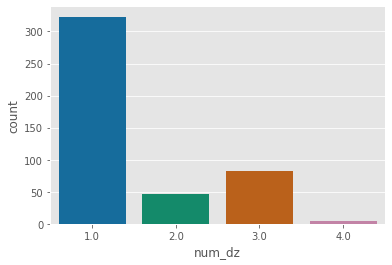

In [249]:
print(common_dz.num_dz.value_counts())
sns.countplot(common_dz.num_dz)


In [259]:
common_dz.num_dz[common_dz.num_dz==4]

gene_sym
C9orf78    4.0
PTGES      4.0
TOR1A      4.0
TOR1B      4.0
USP20      4.0
Name: num_dz, dtype: float64

In [264]:
common_dz.num_dz[common_dz.num_dz==3].sort_index().index

Index(['ABHD15', 'ACTR1A', 'ANKRD13B', 'ARL3', 'AS3MT', 'ATPAF2', 'BLMH',
       'C10orf32', 'CALHM2', 'CORO6', 'CPD', 'CRLF3', 'CYP17A1', 'DDR1',
       'DNAH1', 'DRG2', 'EFCAB5', 'FLOT1', 'GIT1', 'GLT8D1', 'GLYCTK',
       'GLYCTK-AS1', 'GNL3', 'HCG17', 'HCG18', 'HCG27', 'HCG4B', 'HCG4P3',
       'HCG9', 'HLA-A', 'HLA-F', 'HLA-F-AS1', 'HLA-K', 'HLA-L', 'HLA-V',
       'HLA-W', 'IFITM4P', 'ITIH3', 'ITIH4', 'MICD', 'MICE', 'MUSTN1', 'NEK4',
       'NT5C2', 'NT5DC2', 'PEMT', 'POU5F1', 'PPM1M', 'PPP1R11', 'PSORS1C1',
       'PSORS1C2', 'RFT1', 'RNF39', 'RP11-168J18.6', 'RP11-18I14.10',
       'RP11-18I14.7', 'RP11-68I3.11', 'RP5-1157M23.2', 'RPL23AP1', 'RPP21',
       'SERBP1P3', 'SFXN2', 'SH3PXD2A', 'SMIM4', 'SPCS1', 'SREBF1', 'SSH2',
       'SUZ12P', 'TCF19', 'TEFM', 'TMEM110', 'TRIM26', 'TRIM39', 'TRIM8',
       'TWF2', 'USMG5', 'VARS2', 'WDR82', 'XXbac-BPG283O16.9', 'ZDHHC20P1',
       'ZFP57', 'ZNRD1', 'ZNRD1ASP'],
      dtype='object', name='gene_sym')